<a href="https://colab.research.google.com/github/ccg-esb-lab/ARCfitness/blob/main/MonodGillespieARC_1_growth_parametrization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameterization of Strain Growth Dynamics

This notebook calibrates the model parameters that describe bacterial growth under resource limitation.  
For each strain, growth curves measured under aerobic and anaerobic conditions are fitted to a Monod model to estimate the maximum division rate ($V_i$), the half-saturation constant ($K_i$), and the resource consumption per cell division ($c_i$).  
The fitted parameters define the reference strain and serve as the baseline for generating the synthetic library of ARC-bearing competitors.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import os
import copy
import time
import re

from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

from scipy.optimize import curve_fit, minimize, differential_evolution
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from matplotlib.patches import Wedge
from pprint import pprint


## Colone GitHub Repo

In [ ]:
from pathlib import Path

REPO_URL = "https://github.com/ccg-esb-lab/ARCfitness.git"
REPO_DIR = Path("/content/ARCfitness")

if not REPO_DIR.exists():
    %cd /content
    !git clone {REPO_URL}

REPO_ROOT = REPO_DIR.resolve()

print("Repo root:", REPO_ROOT)

# Create local folders for figures and processed simulations.
pathCODE = REPO_ROOT / "code"
pathFIGURES = REPO_ROOT / "figures"
pathSIM = REPO_ROOT / "sim"

pathFIGURES.mkdir(parents=True, exist_ok=True)
pathSIM.mkdir(parents=True, exist_ok=True)



Repo root: /content/ARCfitness


In [ ]:



def _infer_time_col(columns):
    """Pick the time column using common labels; fallback to the first column."""
    candidates = [
        c for c in columns
        if re.search(r"^(time|t)\b", str(c).strip(), flags=re.I)
    ]
    return candidates[0] if candidates else columns[0]


def _to_numeric(df):
    """Coerce all columns to numeric (non-numeric values become NaN)."""
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df




In [ ]:
def load_series_from_csv(repo_root, families, pattern="ARC_{family}.csv"):
    """
    Load multiple CSV exports from the cloned repository.

    Parameters:
    - repo_root: Path object of the cloned repository.
    - families: list of family labels to load exactly.
    - pattern: filename pattern inside data folder; must include {family}.

    Returns:
    - wide_dfs[family]: wide table with time and cassette columns.
    - long_dfs[family]: tidy table with time, cassette, OD, family.
    - combined: concatenated tidy table for all families.
    """
    wide_dfs, long_dfs = {}, {}

    data_path = repo_root / "data"

    for family in families:
        csv_path = data_path / pattern.format(family=family)

        df = pd.read_csv(csv_path)
        df = df.dropna(how="all").dropna(axis=1, how="all")

        time_col = _infer_time_col(df.columns.tolist())
        if time_col != "time":
            df = df.rename(columns={time_col: "time"})

        df = _to_numeric(df)

        wide_dfs[family] = df.copy()

        long = df.melt(id_vars="time",
                       var_name="cassette",
                       value_name="OD").dropna(subset=["OD"])

        long["family"] = family
        long_dfs[family] = long

    combined = pd.concat(long_dfs.values(), ignore_index=True)
    return wide_dfs, long_dfs, combined

families = ["aa", "bla", "dfr", "mix"]
wide_dfs, long_dfs, combined = load_series_from_csv(REPO_ROOT, families)

for family in families:
    preview = list(wide_dfs[family].columns)[:6]
    print(f"{family}: {wide_dfs[family].shape} | columns: {preview} ...")

print(f"combined: {combined.shape} | columns: {list(combined.columns)}")


aa: (145, 175) | columns: ['time', 'pMBA', 'pMBA.1', 'pMBA.2', 'aacA2', 'aacA2.1'] ...
bla: (145, 61) | columns: ['time', 'pMBA', 'pMBA.1', 'pMBA.2', 'BEL1', 'BEL1.1'] ...
dfr: (145, 85) | columns: ['time', 'pMBA', 'pMBA.1', 'pMBA.2', 'dfrA1', 'dfrA1.1'] ...
mix: (145, 103) | columns: ['time', 'pMBA', 'pMBA.1', 'pMBA.2', 'arr2', 'arr2.1'] ...
combined: (60900, 4) | columns: ['time', 'cassette', 'OD', 'family']


In [ ]:
def _base_name(col):
    """Remove replicate suffixes like '.1', '.2' so replicates map to the same strain."""
    return re.sub(r"\.\d+$", "", str(col)).strip()


def summarize_replicates_wide(df):
    """
    Summarize replicate columns in a wide table.

    Expects:
      - A 'time' column (in minutes), plus one or more columns per strain.
      - Replicates are indicated by suffixes like 'strain', 'strain.1', 'strain.2'.

    Returns:
      - strains: sorted list of strain names (replicate suffix removed).
      - summary: tidy table with columns: time (hours), strain, mean_OD, std_OD, n_reps.
    """
    out = df.copy()
    out["time"] = pd.to_numeric(out["time"], errors="coerce") / 60.0  # minutes → hours
    out = out.sort_values("time")

    cols = [c for c in out.columns if c != "time"]
    by_strain = {}
    for c in cols:
        by_strain.setdefault(_base_name(c), []).append(c)

    strains = sorted(by_strain)

    rows = []
    for strain in strains:
        reps = by_strain[strain]
        sub = out[reps].apply(pd.to_numeric, errors="coerce")

        mean = sub.mean(axis=1)
        std = sub.std(axis=1, ddof=1)  # sample SD across replicates
        nreps = sub.notna().sum(axis=1)

        rows.extend(
            {
                "time": t,
                "strain": strain,
                "mean_OD": m,
                "std_OD": s,
                "n_reps": int(n),
            }
            for t, m, s, n in zip(out["time"], mean, std, nreps)
        )

    summary = pd.DataFrame(rows)
    return strains, summary


# Build replicate summaries for each family tab, then combine into one tidy table.
strain_lists, summaries = {}, {}
for family in families:
    strains, summary = summarize_replicates_wide(wide_dfs[family])
    summary["family"] = family

    # Keep only timepoints with at least one observed replicate.
    summary = summary[summary["n_reps"] > 0].reset_index(drop=True)

    strain_lists[family] = strains
    summaries[family] = summary

OD_all = pd.concat(summaries.values(), ignore_index=True)

for family in families:
    print(f"{family}: {len(strain_lists[family])} strains | summary {summaries[family].shape}")
print("OD_all:", OD_all.shape)
print(OD_all)


aa: 58 strains | summary (8410, 6)
bla: 20 strains | summary (2900, 6)
dfr: 28 strains | summary (4060, 6)
mix: 35 strains | summary (5075, 6)
OD_all: (20445, 6)
            time  strain   mean_OD    std_OD  n_reps family
0       0.000000  aacA16  0.107000  0.004359       3     aa
1       0.166667  aacA16  0.111000  0.010440       3     aa
2       0.333333  aacA16  0.115000  0.010149       3     aa
3       0.500000  aacA16  0.111333  0.007506       3     aa
4       0.666667  aacA16  0.110333  0.007095       3     aa
...          ...     ...       ...       ...     ...    ...
20440  23.333333    smr3  1.155500  0.147785       2    mix
20441  23.500000    smr3  1.156000  0.145664       2    mix
20442  23.666667    smr3  1.156500  0.144957       2    mix
20443  23.833333    smr3  1.156000  0.147078       2    mix
20444  24.000000    smr3  1.155500  0.149200       2    mix

[20445 rows x 6 columns]


In [ ]:
def filter_OD(OD_df, strain=None, family=None):
    """Return rows matching strain and family intersections."""
    # Required columns: strain, family. Numeric OD values defined upstream.
    # Filters combine as logical intersection. OD fields remain unchanged.
    df = OD_df.copy()

    if strain is not None:
        strains = [strain] if isinstance(strain, str) else strain
        df = df[df["strain"].isin(strains)]

    if family is not None:
        fams = [family] if isinstance(family, str) else family
        df = df[df["family"].isin(fams)]

    return df.reset_index(drop=True)


subset = filter_OD(OD_all, strain=["BEL1", "aacA2"])
print(subset.head())


       time strain   mean_OD    std_OD  n_reps family
0  0.000000  aacA2  0.126333  0.008083       3     aa
1  0.166667  aacA2  0.120667  0.006028       3     aa
2  0.333333  aacA2  0.126333  0.008505       3     aa
3  0.500000  aacA2  0.130000  0.008718       3     aa
4  0.666667  aacA2  0.130667  0.005033       3     aa


<Axes: title={'center': 'pMBA (log OD)'}, xlabel='Time', ylabel='OD'>

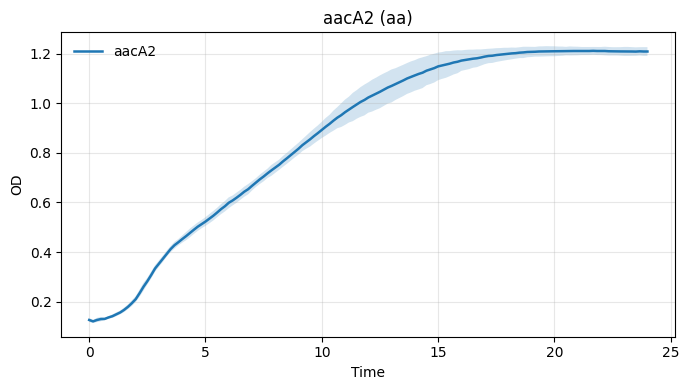

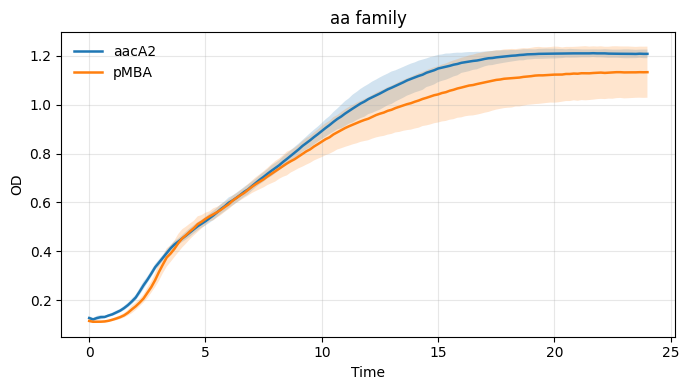

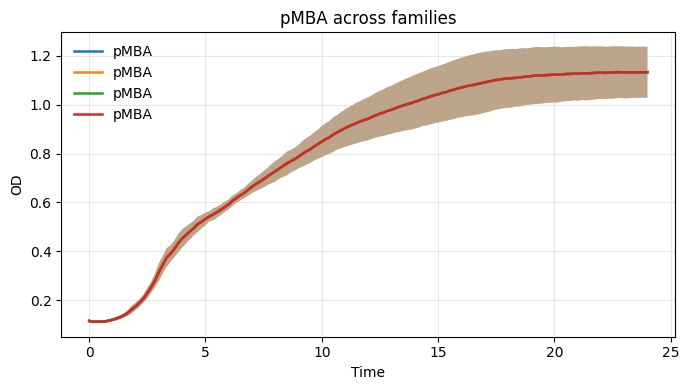

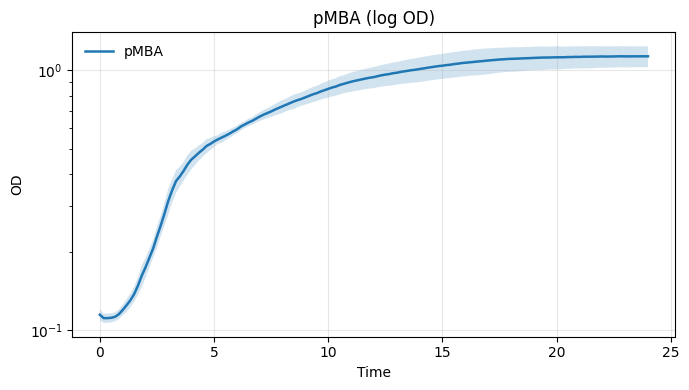

In [ ]:
def plot_OD(OD_all, strain=None, family=None, ax=None,
            ylog=False, title=None, show_legend=True,
            ci="sd", alpha_fill=0.2, linewidth=1.8):
    """Draw OD mean curves from a tidy table prepared upstream."""
    # Requires tidy columns: time, strain, mean_OD, std_OD, n_reps, family.
    # Filters on strain and family act as logical intersections.
    # Empty filters raise an error; OD fields are not modified.

    df = OD_all.copy()

    if strain is not None:
        strains = [strain] if isinstance(strain, str) else list(strain)
        df = df[df["strain"].isin(strains)]

    if family is not None:
        fams = [family] if isinstance(family, str) else list(family)
        df = df[df["family"].isin(fams)]

    if df.empty:
        raise ValueError("No data to plot after filtering. Check strain or family names.")

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df = df.dropna(subset=["time", "mean_OD"]) \
           .sort_values(["strain", "family", "time"])

    created_fig = False
    if ax is None:
        created_fig = True
        fig, ax = plt.subplots(figsize=(7, 4))

    for (fam, st), g in df.groupby(["family", "strain"], sort=False):
        t = g["time"].to_numpy()
        m = g["mean_OD"].astype(float).to_numpy()
        s = g["std_OD"].astype(float).to_numpy()
        n = g["n_reps"].astype(float).to_numpy()

        ax.plot(t, m, label=st, linewidth=linewidth)

        if ci in ("sd", "sem"):
            band = s if ci == "sd" else (s / np.sqrt(np.maximum(n, 1)))
            ax.fill_between(t, m - band, m + band, alpha=alpha_fill)

    ax.set_xlabel("Time")
    ax.set_ylabel("OD")

    if ylog:
        ax.set_yscale("log")

    if title:
        ax.set_title(title)

    if show_legend:
        ax.legend(loc="best", frameon=False)

    ax.grid(True, alpha=0.3)

    if created_fig:
        plt.tight_layout()

    return ax



# Single strain in one family
plot_OD(OD_all, strain='aacA2', family='aa', title='aacA2 (aa)')

# Multiple strains from the same family
plot_OD(OD_all, strain=['aacA2','pMBA'], family='aa', title='aa family')

# Compare the same strain across families
plot_OD(OD_all, strain='pMBA', family=['aa','bla','dfr','mix'],
        title='pMBA across families')

# Log-scale y-axis
plot_OD(OD_all, strain='pMBA', family='aa', ylog=True, title='pMBA (log OD)')


## Set experimental parameters

In [ ]:

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
antibiotic_concentration = 0.0  # No antibiotics
B0=1e8
od2cells = 1e9


## Simple Model

In [ ]:
def gillespie_bacterial_growth_batch(strains, initial_resource, simulation_time,
                                     antibiotic_concentration, dt=0.1,
                                     num_simulations=3):
    """Batch stochastic simulation for resource-limited growth and antibiotic-modulated death.
    Requires a tidy table upstream with numeric values and strain parameter fields
    initial_population, birth_rate, death_rate, K, A_half, and c.
    Birth events are scaled by the resource term R/(R + K).
    Death events are scaled by the antibiotic term A/(A + A_half).
    Resource decreases by coefficient c per division across all strains.
    When population or resource reach zero, only time advances by dt.
    """
    all_t_values, all_population_values, all_R_values = [], [], []

    for sim in range(num_simulations):
        t = 0.0
        populations = [strain["initial_population"] for strain in strains]
        R = initial_resource

        t_values = [t]
        population_values = [populations[:]]
        R_values = [R]

        while t < simulation_time:
            if sum(populations) <= 0 or R <= 0:
                t += dt
                t_values.append(t)
                population_values.append(populations[:])
                R_values.append(R)
                continue

            births = [
                np.random.poisson(
                    strain["birth_rate"] * populations[i] *
                    (R / (R + strain["K"])) * dt
                )
                for i, strain in enumerate(strains)
            ]

            deaths = [
                np.random.poisson(
                    strain["death_rate"] * populations[i] *
                    (antibiotic_concentration /
                     (antibiotic_concentration + strain["A_half"])) * dt
                )
                for i, strain in enumerate(strains)
            ]

            for i in range(len(populations)):
                populations[i] += births[i] - deaths[i]

            R -= sum(births[i] * strains[i]["c"] for i in range(len(strains)))
            populations = [max(0, pop) for pop in populations]
            R = max(R, 0)

            t += dt
            t_values.append(t)
            population_values.append(populations[:])
            R_values.append(R)

        all_t_values.append(t_values)
        all_population_values.append(population_values)
        all_R_values.append(R_values)

    return (np.mean(all_t_values, axis=0),
            np.mean(all_population_values, axis=0),
            np.mean(all_R_values, axis=0))


In [ ]:
def plotSimulation(time_points, population_values, resource):
    """
    Plot the simulation results for multiple strains and resource depletion.

    Parameters:
    - time_points: list of time values in hours.
    - population_values: list of lists with population size of each strain.
      First list element defines the number of strains.
    - resource: list with remaining resource relative to initial level.
    """
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)

    num_strains = len(population_values[0])

    for i in range(num_strains):
        axes[0].plot(time_points,
                     [pop[i] for pop in population_values],
                     label=f"Strain {i}")

    axes[0].set_xlabel("Time (hours)", fontsize=14)
    axes[0].set_ylabel("Population", fontsize=14)
    axes[0].set_yscale("log")

    axes[1].plot(time_points, resource, label="Resource")
    axes[1].set_xlabel("Time (hours)", fontsize=14)
    axes[1].set_ylabel("Resource concentration", fontsize=14)
    axes[1].set_ylim([0, 1.1])

    plt.show()


## Determination of Monod parameters

In [ ]:

def get_od_by_strain_family(OD_all, strain, family=None, as_numpy=True):
    """
    Get OD values for one strain from a tidy table.

    Parameters:
    - OD_all: pandas DataFrame in tidy format prepared upstream.
    - strain: string with strain label to match exactly.
    - family: optional string with family label. If None, use all families
      and aggregate by time.
    - as_numpy: optional boolean to return numpy arrays.

    Returns:
    - mean_OD, std_OD, time sorted ascending.
    """
    df = OD_all.copy()
    df = df[df["strain"] == strain]

    if family is not None:
        df = df[df["family"] == family]

    if df.empty:
        raise ValueError("No data for the requested strain or family.")

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df = df.dropna(subset=["time"]).sort_values("time")

    # Aggregate when multiple families share the same time grid.
    agg = df.groupby("time", as_index=False).agg(
        mean_OD=("mean_OD", "mean"),
        std_OD=("std_OD", "mean"),
    )

    return (agg["mean_OD"].to_numpy(),
            agg["std_OD"].to_numpy(),
            agg["time"].to_numpy()) if as_numpy else (
            agg["mean_OD"], agg["std_OD"], agg["time"])


def get_od_from_wide(wide_df, strain_base, as_numpy=True):
    """
    Get OD values for one strain from a wide table.

    Parameters:
    - wide_df: pandas DataFrame with time column and replicate columns
      prepared upstream.
    - strain_base: string with base strain label to match exactly.
    - as_numpy: optional boolean to return numpy arrays.

    Returns:
    - mean_OD, std_OD, time sorted ascending.
    """
    df = wide_df.copy()

    if "time" not in df.columns:
        raise ValueError("time column not found in wide table.")

    replicate_cols = [
        c for c in df.columns
        if c != "time" and _base_name(c) == strain_base
    ]

    if not replicate_cols:
        raise ValueError("No replicate columns for the requested strain.")

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df = df.dropna(subset=["time"]).sort_values("time")

    sub = df[replicate_cols].apply(pd.to_numeric, errors="coerce")

    mean_od = sub.mean(axis=1)
    std_od = sub.std(axis=1, ddof=1).fillna(0.0)  # single replicate → 0
    time = df["time"]

    return (mean_od.to_numpy(),
            std_od.to_numpy(),
            time.to_numpy()) if as_numpy else (
            mean_od, std_od, time)


def convert_od_to_cell_density(mean_od, std_od, od2cells):
    """Convert OD to cell density using a scalar factor od2cells."""
    # The factor od2cells must be defined upstream in cells per OD unit.
    return mean_od * od2cells, std_od * od2cells


mean_od, std_od, t = get_od_by_strain_family(OD_all, strain="aacA2", family="aa")
mean_cells, std_cells = convert_od_to_cell_density(mean_od, std_od, od2cells)

mean_od_w, std_od_w, t_w = get_od_from_wide(wide_dfs["aa"], strain_base="aacA2")


In [ ]:
import copy
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, least_squares


def get_target_from_ODall(OD_all, strain, family=None, od2cells=od2cells, min_std=1e-4):
    """
    Extract a strain time series from OD_all and convert OD to cells.

    Parameters:
    - OD_all: tidy DataFrame with columns time, mean_OD, std_OD, strain, family.
    - strain: strain label to match exactly.
    - family: optional family label to match exactly.
    - od2cells: scalar conversion factor (cells per OD unit).
    - min_std: lower bound on std_OD (in OD units) to regularize weights.

    Returns:
    - t: numpy array of time values (sorted).
    - y: numpy array of mean cell density.
    - w: numpy array of weights defined as 1 / std_cells^2.
    """
    df = OD_all.copy()
    df = df[df["strain"] == strain]
    if family is not None:
        df = df[df["family"] == family]
    if df.empty:
        raise ValueError(f"No data for strain='{strain}' family='{family}'.")

    df = df[["time", "mean_OD", "std_OD"]].dropna(subset=["time", "mean_OD"])
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df = df.dropna(subset=["time"]).sort_values("time")

    mean_cells = df["mean_OD"].to_numpy(dtype=float) * od2cells
    std_cells = df["std_OD"].fillna(0.0).to_numpy(dtype=float) * od2cells
    std_cells = np.maximum(std_cells, min_std * od2cells)

    t = df["time"].to_numpy(dtype=float)
    w = 1.0 / (std_cells ** 2)
    return t, mean_cells, w


def simulate_to_times(params, sim_fn, t_meas, base_strain_params,
                      initial_resource, simulation_time):
    """
    Run the simulator with fitted parameters and interpolate to measurement times.

    Parameters:
    - params: iterable (birth_rate, K, c) applied to strains[0].
    - sim_fn: simulation function returning (time, population_values, meta).
    - t_meas: array of measurement times to evaluate the simulation on.
    - base_strain_params: list of strain dicts used as template for simulation.
    - initial_resource, simulation_time: simulator settings.

    Returns:
    - y_sim: simulated population of strain 0 evaluated at t_meas.
    """
    birth_rate, K, c = params

    strains = copy.deepcopy(base_strain_params)
    strains[0]["birth_rate"] = float(birth_rate)
    strains[0]["K"] = float(K)
    strains[0]["c"] = float(c)

    sim_time, population_values, _ = sim_fn(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentration=0.0,
    )

    sim_time = np.asarray(sim_time, dtype=float)
    pop = np.asarray([p[0] for p in population_values], dtype=float)

    return np.interp(t_meas, sim_time, pop)


def objective_time_series(params, t_meas, y_meas, weights,
                          sim_fn, base_strain_params,
                          initial_resource, simulation_time,
                          use_log=False, penalty=np.inf):
    """
    Weighted sum of squared errors between simulation and data.

    Parameters:
    - use_log: if True, compute residuals in log space.
    - weights: weights per time point, typically 1 / sigma^2.

    Returns:
    - SSE (float), or penalty on simulation failure / non-finite values.
    """
    try:
        y_hat = simulate_to_times(params, sim_fn, t_meas, base_strain_params,
                                  initial_resource, simulation_time)

        if use_log:
            y_meas_safe = np.maximum(y_meas, 1e-12)
            y_hat_safe = np.maximum(y_hat, 1e-12)
            resid = np.log(y_hat_safe) - np.log(y_meas_safe)
        else:
            resid = y_hat - y_meas

        if weights is not None:
            resid = resid * np.sqrt(weights)

        if not np.all(np.isfinite(resid)):
            return penalty

        return float(np.sum(resid ** 2))

    except Exception:
        return penalty


def fit_strain_OD(
    OD_all, strain, family,
    sim_fn,
    base_strain_params,
    initial_resource, simulation_time,
    bounds=((0.1, 5.0), (1e-3, 5.0), (1e-12, 1e-6)),
    initial_guess=(1.0, 0.5, 5e-9),
    use_log=False,
    od2cells=od2cells,
    optimizer="de",
    maxiter=500,
):
    """
    Fit (birth_rate, K, c) to a single strain OD time series.

    Parameters:
    - sim_fn: simulation function used to generate predicted trajectories.
    - base_strain_params: list of strain dicts; parameters are applied to strains[0].
    - bounds: parameter bounds for (birth_rate, K, c).
    - optimizer: "de" for differential evolution, otherwise least_squares from initial_guess.
    - use_log: if True, fit in log space.

    Returns:
    - dict with fitted parameters, observed series, predicted series, and SSE.
    """
    t, y, w = get_target_from_ODall(OD_all, strain=strain, family=family, od2cells=od2cells)

    def obj(p):
        return objective_time_series(
            p, t, y, w, sim_fn, base_strain_params,
            initial_resource, simulation_time, use_log=use_log
        )

    if optimizer == "de":
        result = differential_evolution(
            obj, bounds=bounds, maxiter=maxiter, tol=1e-3, polish=True, popsize=20
        )
        p_opt = result.x
        fun = result.fun
    else:
        def resid(p):
            y_hat = simulate_to_times(p, sim_fn, t, base_strain_params, initial_resource, simulation_time)
            if use_log:
                y_hat = np.maximum(y_hat, 1e-12)
                y_obs = np.maximum(y, 1e-12)
                r = np.log(y_hat) - np.log(y_obs)
            else:
                r = y_hat - y
            if w is not None:
                r = r * np.sqrt(w)
            return r

        lsq = least_squares(
            resid,
            x0=np.asarray(initial_guess, dtype=float),
            bounds=np.asarray(list(zip(*bounds))),
        )
        p_opt = lsq.x
        fun = float(np.sum(resid(p_opt) ** 2))

    y_hat = simulate_to_times(p_opt, sim_fn, t, base_strain_params, initial_resource, simulation_time)

    return {
        "params": {"birth_rate": p_opt[0], "K": p_opt[1], "c": p_opt[2]},
        "time": t,
        "y_obs": y,
        "y_hat": y_hat,
        "SSE": fun,
        "use_log": use_log,
        "weights": w,
    }


In [ ]:
def plot_simulation_with_OD(
    time_points,
    population_values,
    resource=None,
    OD_all=None,
    strain=None,
    family=None,
    od2cells=od2cells,
    unit="cells",
    strain_index=0,
    title=None,
    ylog=True,
    show_resource=True,
    ci="sd",
):
    """
    Plot a simulated trajectory and optionally overlay observed OD data.

    Parameters:
    - time_points: array-like simulation times (hours).
    - population_values: array-like with population_values[k][i] = population of strain i at time k.
    - resource: optional array-like resource trajectory over time.
    - OD_all: optional tidy DataFrame with columns time, strain, mean_OD, std_OD, n_reps, family.
    - strain: optional strain label to select from OD_all.
    - family: optional family label to select from OD_all.
    - od2cells: conversion factor (cells per OD unit) used when unit='cells'.
    - unit: 'OD' or 'cells' for y-axis and simulation scaling.
    - strain_index: index of simulated strain to plot from population_values.
    - title: optional plot title.
    - ylog: if True, use log scale for the population axis.
    - show_resource: if True and resource is provided, add a resource subplot.
    - ci: 'sd', 'sem', or None for observed error bars.
    """
    time_points = np.asarray(time_points, dtype=float)
    pop_arr = np.asarray(population_values, dtype=float)
    if pop_arr.ndim == 1:
        pop_arr = pop_arr[:, None]
    y_sim_cells = pop_arr[:, strain_index]

    if unit.lower() == "od":
        y_sim = y_sim_cells / float(od2cells)
        y_label = "OD"
    else:
        y_sim = y_sim_cells
        y_label = "Cells"

    if show_resource and resource is not None:
        fig, axes = plt.subplots(2, 1, figsize=(7, 6), constrained_layout=True)
        ax_pop, ax_res = axes
    else:
        fig, ax_pop = plt.subplots(1, 1, figsize=(7, 4))
        ax_res = None

    ax_pop.plot(time_points, y_sim, label="Simulation", linewidth=2)

    if OD_all is not None and strain is not None:
        df = OD_all.copy()
        df = df[df["strain"] == strain]
        if family is not None:
            df = df[df["family"] == family]

        if not df.empty:
            df = df[["time", "mean_OD", "std_OD", "n_reps"]].dropna(subset=["time", "mean_OD"])
            df["time"] = pd.to_numeric(df["time"], errors="coerce")
            df = df.dropna(subset=["time"]).sort_values("time")

            if unit.lower() == "od":
                y_obs = df["mean_OD"].to_numpy(dtype=float)
                err = df["std_OD"].to_numpy(dtype=float)
            else:
                y_obs = df["mean_OD"].to_numpy(dtype=float) * float(od2cells)
                err = df["std_OD"].to_numpy(dtype=float) * float(od2cells)

            if ci == "sem":
                n = df["n_reps"].to_numpy(dtype=float)
                n = np.where(n <= 0, 1.0, n)
                err = err / np.sqrt(n)

            ax_pop.errorbar(
                df["time"].to_numpy(dtype=float),
                y_obs,
                yerr=err if ci in ("sd", "sem") else None,
                fmt="o",
                ms=3.5,
                lw=1.2,
                capsize=2.5,
                label=f"Observed: {strain}" + (f" ({family})" if family else ""),
            )
        else:
            print(f"[plot] No observed data for strain='{strain}' family='{family}'")

    ax_pop.set_xlabel("Time (hours)")
    ax_pop.set_ylabel(y_label)

    if ylog:
        ax_pop.set_yscale("log")
    if title:
        ax_pop.set_title(title)

    ax_pop.grid(True, alpha=0.3)
    ax_pop.legend(frameon=False)

    if ax_res is not None:
        ax_res.plot(time_points, np.asarray(resource, dtype=float), label="Resource", linewidth=2)
        ax_res.set_xlabel("Time (hours)")
        ax_res.set_ylabel("Resource")
        ax_res.set_ylim(bottom=0)
        ax_res.grid(True, alpha=0.3)

    plt.tight_layout()
    return (ax_pop, ax_res) if ax_res is not None else ax_pop


def plot_fit_result(fit, unit="OD", od2cells=od2cells, title=None, ylog=True):
    """
    Plot observed vs fitted trajectory from a fit dict returned by fit_strain_OD.

    Parameters:
    - fit: dict with keys time, y_obs (cells), y_hat (cells).
    - unit: 'OD' or 'cells' for plotting scale.
    - od2cells: conversion factor (cells per OD unit) used when unit='OD'.
    - title: optional plot title.
    - ylog: if True, use log scale for the population axis.
    """
    t = np.asarray(fit["time"], dtype=float)
    y_obs_cells = np.asarray(fit["y_obs"], dtype=float)
    y_hat_cells = np.asarray(fit["y_hat"], dtype=float)

    if unit.lower() == "od":
        y_obs = y_obs_cells / float(od2cells)
        y_hat = y_hat_cells / float(od2cells)
        y_label = "OD"
    else:
        y_obs = y_obs_cells
        y_hat = y_hat_cells
        y_label = "Cells"

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t, y_hat, label="Simulation (fit)", linewidth=2)
    ax.plot(t, y_obs, "o", ms=4, label="Observed")

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel(y_label)

    if ylog:
        ax.set_yscale("log")
    if title:
        ax.set_title(title)

    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)
    plt.tight_layout()
    return ax


In [ ]:
def make_optimized_strains(base_strain_params, fit_params):
    """
    Create a strain-parameter list with fitted values injected into strain 0.

    Parameters:
    - base_strain_params: list of strain dicts used as a template.
    - fit_params: dict with keys birth_rate, K, c.

    Returns:
    - deep-copied list of strain dicts with updated parameters.
    """
    strains = copy.deepcopy(base_strain_params)
    strains[0]["birth_rate"] = float(fit_params["birth_rate"])
    strains[0]["K"] = float(fit_params["K"])
    strains[0]["c"] = float(fit_params["c"])
    return strains


def run_sim_from_fit(fit, base_strain_params, sim_fn,
                     initial_resource, simulation_time,
                     antibiotic_concentration=0.0):
    """
    Run the simulator using fitted parameters.

    Parameters:
    - fit: dict returned by fit_strain_OD containing fit['params'].
    - base_strain_params: list of strain dicts used as a template.
    - sim_fn: simulator function.
    - initial_resource, simulation_time, antibiotic_concentration: simulator settings.

    Returns:
    - sim_time, population_values, resource (None if not returned by sim_fn).
    """
    strains_opt = make_optimized_strains(base_strain_params, fit["params"])
    out = sim_fn(
        strains=strains_opt,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentration=antibiotic_concentration,
    )

    if len(out) == 2:
        sim_time, population_values = out
        resource = None
    else:
        sim_time, population_values, resource = out

    return sim_time, population_values, resource


=== Fit Summary ===
Birth rate        : 0.9425
K (half-sat res.) : 1.9994
Consumption rate  : 1.0667e-09
SSE               : 4.431e+02
R²                : 0.9694


/tmp/ipython-input-9178700.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(<Axes: title={'center': 'pMBA (dfr)'}, xlabel='Time (hours)', ylabel='Cells'>,
 <Axes: xlabel='Time (hours)', ylabel='Resource'>)

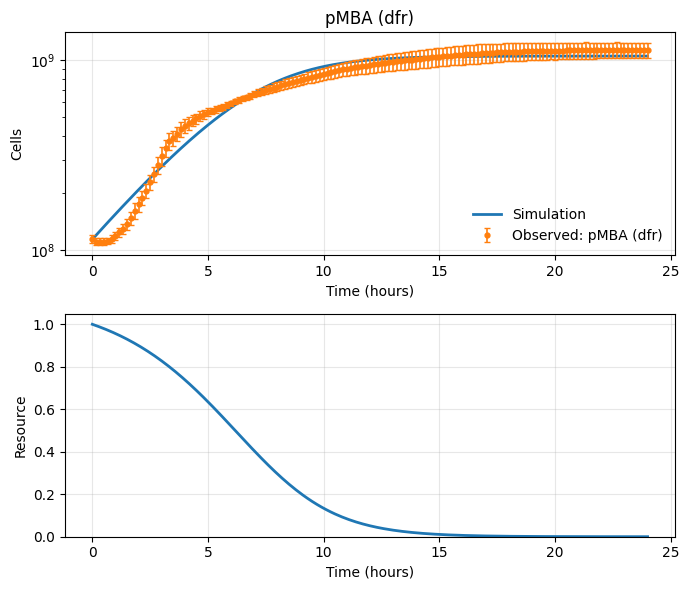

In [ ]:
this_strain = "pMBA"
this_family = "dfr"

df0 = OD_all.loc[
    (OD_all["strain"] == this_strain) & (OD_all["family"] == this_family),
    ["time", "mean_OD"],
].copy()

df0["time"] = pd.to_numeric(df0["time"], errors="coerce")
df0 = df0.dropna(subset=["time", "mean_OD"]).sort_values("time")

if df0.empty:
    raise ValueError(
        f"No data for strain='{this_strain}', family='{this_family}'. "
        f"Available strains: {OD_all['strain'].unique()[:5]} ..."
    )

N0 = float(df0.iloc[0]["mean_OD"]) * od2cells

base_strain_params = [{
    "birth_rate": 1.0,
    "death_rate": 0.0,
    "initial_population": N0,
    "K": 0.5,
    "c": 5e-9,
    "A_half": 0.5,
}]

fit = fit_strain_OD(
    OD_all, strain=this_strain, family=this_family,
    sim_fn=gillespie_bacterial_growth_batch,
    base_strain_params=base_strain_params,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    bounds=((0.1, 3.0), (0.05, 2.0), (1e-10, 2e-8)),
    initial_guess=(1.0, 0.5, 5e-9),
    use_log=False,
    optimizer="de",
    maxiter=600,
)

y_obs = fit["y_obs"]
y_hat = fit["y_hat"]

ss_res = np.sum((y_obs - y_hat) ** 2)
ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)
r2 = 1.0 - ss_res / ss_tot

print("=== Fit Summary ===")
print(f"Birth rate        : {fit['params']['birth_rate']:.4f}")
print(f"K (half-sat res.) : {fit['params']['K']:.4f}")
print(f"Consumption rate  : {fit['params']['c']:.4e}")
print(f"SSE               : {fit['SSE']:.3e}")
print(f"R²                : {r2:.4f}")

sim_time_p, final_population_values_p, resource_p = run_sim_from_fit(
    fit,
    base_strain_params=base_strain_params,
    sim_fn=gillespie_bacterial_growth_batch,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
)

plot_simulation_with_OD(
    time_points=sim_time_p,
    population_values=final_population_values_p,
    resource=resource_p,
    OD_all=OD_all,
    strain=this_strain,
    family=this_family,
    unit="cells",
    od2cells=od2cells,
    strain_index=0,
    title=f"{this_strain} ({this_family})",
    ylog=True,
    ci="sd",
)


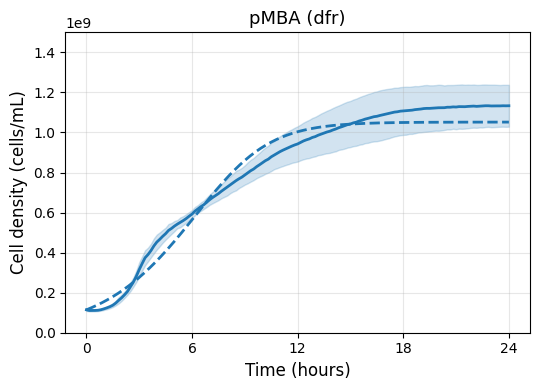

In [ ]:
def _obs_cells_from_OD(OD_all, strain, family, od2cells=od2cells):
    """
    Extract observed mean and SD from OD_all and convert OD to cells.

    Parameters:
    - OD_all: tidy DataFrame with columns time, strain, family, mean_OD, std_OD.
    - strain: strain label to match exactly.
    - family: family label to match exactly.
    - od2cells: conversion factor (cells per OD unit).

    Returns:
    - t: numpy array of time values (hours, sorted).
    - mean_cells: numpy array of mean cell density.
    - std_cells: numpy array of SD in cell density (0 if missing).
    """
    df = OD_all.loc[
        (OD_all["strain"] == strain) & (OD_all["family"] == family),
        ["time", "mean_OD", "std_OD"],
    ].copy()

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df = df.dropna(subset=["time", "mean_OD"]).sort_values("time")

    t = df["time"].to_numpy(float)
    mean_cells = df["mean_OD"].to_numpy(float) * od2cells
    std_cells = df["std_OD"].fillna(0.0).to_numpy(float) * od2cells
    return t, mean_cells, std_cells


def plot_fit_cells_single(OD_all, strain, family, fit,
                          base_strain_params, sim_fn,
                          initial_resource, simulation_time,
                          od2cells=od2cells, color="C0", ymax=None, ylog=False,
                          title=None, strain_index=0):
    """
    Plot observed mean ± SD (cells) and the fitted simulation trajectory.

    Parameters:
    - OD_all: tidy DataFrame with observed OD summary statistics.
    - strain, family: labels used to select the observed series.
    - fit: dict returned by fit_strain_OD with fit['params'].
    - base_strain_params: template strain dict list used for the simulator.
    - sim_fn: simulator function returning (time, populations) or (time, populations, resource).
    - initial_resource, simulation_time: simulator settings.
    - od2cells: conversion factor (cells per OD unit).
    - color: matplotlib color for both observed and simulated curves.
    - ymax: optional y-axis upper limit.
    - ylog: if True, use log scale on y-axis.
    - strain_index: index of simulated strain to plot from the population matrix.

    Returns:
    - matplotlib Axes.
    """
    t_obs, mean_cells, std_cells = _obs_cells_from_OD(OD_all, strain, family, od2cells=od2cells)

    strains_opt = make_optimized_strains(base_strain_params, fit["params"])
    out = sim_fn(
        strains=strains_opt,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentration=0.0,
    )

    if len(out) == 2:
        t_sim, pop = out
    else:
        t_sim, pop, _ = out

    pop = np.asarray(pop, float)
    sim_cells = pop[:, strain_index]

    fig, ax = plt.subplots(figsize=(5.5, 4))

    ax.plot(t_obs, mean_cells, "-", color=color, lw=2)
    ax.fill_between(t_obs, mean_cells - std_cells, mean_cells + std_cells, color=color, alpha=0.20)
    ax.plot(np.asarray(t_sim, float), sim_cells, "--", color=color, lw=2)

    ax.set_xlabel("Time (hours)", fontsize=12)
    ax.set_ylabel("Cell density (cells/mL)", fontsize=12)

    if title:
        ax.set_title(title, fontsize=13)

    ax.grid(True, alpha=0.3)

    x_min = float(np.min(t_obs))
    x_max = float(max(np.max(t_obs), np.max(t_sim)))
    xticks = [0, 6, 12, 18, 24]
    xticks = [x for x in xticks if x_min - 1e-9 <= x <= x_max + 1e-9]
    if xticks:
        ax.set_xticks(xticks)

    if ylog:
        ax.set_yscale("log")
    if ymax is not None:
        ax.set_ylim(0, ymax)

    plt.tight_layout()
    return ax


ax = plot_fit_cells_single(
    OD_all, strain=this_strain, family=this_family, fit=fit,
    base_strain_params=base_strain_params,
    sim_fn=gillespie_bacterial_growth_batch,
    initial_resource=initial_resource, simulation_time=simulation_time,
    od2cells=od2cells, color="#1f77b4", ymax=1.5e9, ylog=False,
    title=f"{this_strain} ({this_family})",
)


In [ ]:


def _get_or_create_ws(sheet, title):
    """Return an existing worksheet or create it if missing."""
    try:
        return sheet.worksheet(title)
    except Exception:
        return sheet.add_worksheet(title=title, rows=100, cols=20)


def save_fit_to_csv(csv_path, fit, strain, family, N0,
                    optimizer="de", od2cells=od2cells, extra=None):
    """
    Write or update a single fit result in a CSV file keyed by (family, strain).

    Parameters:
    - csv_path: output CSV filepath.
    - fit: dict returned by fit_strain_OD.
    - strain, family: identifiers used as the upsert key.
    - N0: initial population used for the fit (cells).
    - optimizer: label stored for provenance.
    - od2cells: OD to cells conversion factor stored for provenance.
    - extra: optional dict of additional scalar metadata to append as columns.
    """
    row = {
        "timestamp_utc": pd.Timestamp.utcnow().isoformat(),
        "family": family,
        "strain": strain,
        "birth_rate": float(fit["params"]["birth_rate"]),
        "K": float(fit["params"]["K"]),
        "c": float(fit["params"]["c"]),
        "SSE": float(fit["SSE"]),
        "n_points": int(len(fit["time"])),
        "use_log": bool(fit.get("use_log", False)),
        "optimizer": optimizer,
        "N0_cells": float(N0),
        "OD_to_cells": float(od2cells),
    }

    y_obs = pd.Series(fit["y_obs"], dtype=float)
    y_hat = pd.Series(fit["y_hat"], dtype=float)
    ss_res = float(((y_obs - y_hat) ** 2).sum())
    ss_tot = float(((y_obs - y_obs.mean()) ** 2).sum())
    row["R2"] = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")

    if isinstance(extra, dict):
        row.update(extra)

    new_df = pd.DataFrame([row])

    csv_path = Path(csv_path)
    csv_path.parent.mkdir(parents=True, exist_ok=True)

    if csv_path.exists():
        existing = pd.read_csv(csv_path)
        existing = existing.dropna(how="all").dropna(axis=1, how="all")
    else:
        existing = pd.DataFrame()

    if not existing.empty:
        for col in new_df.columns:
            if col not in existing.columns:
                existing[col] = pd.NA
        for col in existing.columns:
            if col not in new_df.columns:
                new_df[col] = pd.NA

        existing["family"] = existing["family"].astype("string")
        existing["strain"] = existing["strain"].astype("string")
        new_df["family"] = new_df["family"].astype("string")
        new_df["strain"] = new_df["strain"].astype("string")

        mask = (existing["family"] == family) & (existing["strain"] == strain)
        out_df = existing
        if mask.any():
            out_df.loc[mask, new_df.columns] = new_df.iloc[0].values
        else:
            out_df = pd.concat([existing, new_df], ignore_index=True)
    else:
        out_df = new_df

    out_df.to_csv(csv_path, index=False)
    print(f"Saved fit for {family}/{strain} to '{csv_path}'.")


## Parameterize all strains

In [ ]:
# Get unique families
families = OD_all['family'].dropna().unique()

# Dictionary: family → list of strains
family_strain_map = {
    fam: sorted(OD_all.loc[OD_all['family'] == fam, 'strain'].dropna().unique())
    for fam in families
}

for fam, strains in family_strain_map.items():
    print(f"{fam}: {', '.join(strains)}")

pairs = OD_all[['family', 'strain']].dropna().drop_duplicates()
pairs_list = list(map(tuple, pairs.to_numpy()))



aa: aacA16, aacA17, aacA2, aacA27, aacA28, aacA29, aacA3, aacA30, aacA31, aacA34, aacA35, aacA37, aacA38, aacA4, aacA42, aacA43, aacA45, aacA47, aacA48, aacA49, aacA50, aacA51, aacA52, aacA54, aacA56, aacA59, aacA61, aacA64, aacA7, aacA8, aacAX, aacC1, aacC11, aacC13, aacC2, aacC3, aacC4, aacC5, aacC6, aadA1, aadA10, aadA11, aadA13, aadA16, aadA2, aadA24, aadA28, aadA29, aadA34, aadA4, aadA5, aadA6, aadA7, aadB, aphA15, aphA16, pMBA, sat2
bla: BEL1, GES1, IMP2, IMP31, OXA1, OXA10, OXA118, OXA129, OXA198, OXA2, OXA20, OXA21, OXA46, OXA5, OXA9, PBL1, VIM1, VIM2, VIM7, pMBA
dfr: dfrA1, dfrA12, dfrA14, dfrA15, dfrA16, dfrA17, dfrA21, dfrA22, dfrA25, dfrA27, dfrA29, dfrA30, dfrA31, dfrA34, dfrA35, dfrA5, dfrA6, dfrA7, dfrB1, dfrB2, dfrB3, dfrB4, dfrB5, dfrB6, dfrB7, dfrB8, dfrB9, pMBA
mix: arr2, arr5, arr6, arr7, arr8b, catB10, catB2, catB3, catB5, catB6, ereA2, ereA3, fosC2, fosE, fosF, fosG, fosH, fosI, fosK, fosL, fosM, fosN, pMBA, qacE, qacEDsul1, qacF, qacG, qacH, qacK, qacL, qacM, sm3

In [ ]:
def fit_ODdata(
    OD_all, strain, family,
    sim_fn,
    initial_resource, simulation_time,
    od2cells=od2cells,
    bounds=((0.1, 3.0), (0.05, 2.0), (1e-10, 2e-8)),
    initial_guess=(1.0, 0.5, 5e-9),
    color="#1f77b4", ymax=1.5e9, ylog=False,
):
    """
    Fit (birth_rate, K, c) to a single strain OD time series and plot the result.

    Parameters:
    - OD_all: tidy DataFrame with columns time, strain, family, mean_OD, std_OD, n_reps.
    - strain, family: labels used to select the observed time series.
    - sim_fn: simulator function used by fit_strain_OD.
    - initial_resource, simulation_time: simulator settings.
    - od2cells: conversion factor (cells per OD unit).
    - bounds: parameter bounds for (birth_rate, K, c).
    - initial_guess: starting point for local optimization (used if configured downstream).
    - color, ymax, ylog: plotting settings.

    Returns:
    - N0: initial population inferred from the earliest observation (cells).
    - fit: dict returned by fit_strain_OD.
    - ax: matplotlib Axes with observed and simulated trajectories.
    """
    df0 = OD_all.loc[
        (OD_all["strain"] == strain) & (OD_all["family"] == family),
        ["time", "mean_OD"],
    ].copy()

    df0["time"] = pd.to_numeric(df0["time"], errors="coerce")
    df0 = df0.dropna(subset=["time", "mean_OD"]).sort_values("time")

    if df0.empty:
        raise ValueError(f"No data for strain='{strain}', family='{family}'")

    N0 = float(df0.iloc[0]["mean_OD"]) * float(od2cells)

    base_strain_params = [{
        "birth_rate": 1.0,
        "death_rate": 0.0,
        "initial_population": N0,
        "K": 0.5,
        "c": 5e-9,
        "A_half": 0.5,
    }]

    fit = fit_strain_OD(
        OD_all, strain=strain, family=family,
        sim_fn=sim_fn,
        base_strain_params=base_strain_params,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        bounds=bounds,
        initial_guess=initial_guess,
        use_log=False,
        optimizer="de",
        maxiter=600,
    )

    y_obs = fit["y_obs"]
    y_hat = fit["y_hat"]
    ss_res = np.sum((y_obs - y_hat) ** 2)
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print("=== Fit Summary ===")
    print(f"Strain/Family     : {strain} / {family}")
    print(f"Birth rate        : {fit['params']['birth_rate']:.4f}")
    print(f"K                 : {fit['params']['K']:.4f}")
    print(f"Consumption rate  : {fit['params']['c']:.4e}")
    print(f"SSE               : {fit['SSE']:.3e}")
    print(f"R²                : {r2:.4f}")

    sim_time_p, final_population_values_p, _ = run_sim_from_fit(
        fit,
        base_strain_params=base_strain_params,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
    )

    ax = plot_fit_cells_single(
        OD_all, strain=strain, family=family, fit=fit,
        base_strain_params=base_strain_params,
        sim_fn=sim_fn,
        initial_resource=initial_resource, simulation_time=simulation_time,
        od2cells=od2cells, color=color, ymax=ymax, ylog=ylog,
        title=f"{strain} ({family})",
    )

    return N0, fit, ax


=== Fit Summary ===
Strain/Family     : aacA16 / aa
Birth rate        : 0.8040
K                 : 1.9994
Consumption rate  : 1.5239e-09
SSE               : 4.611e+02
R²                : 0.8504


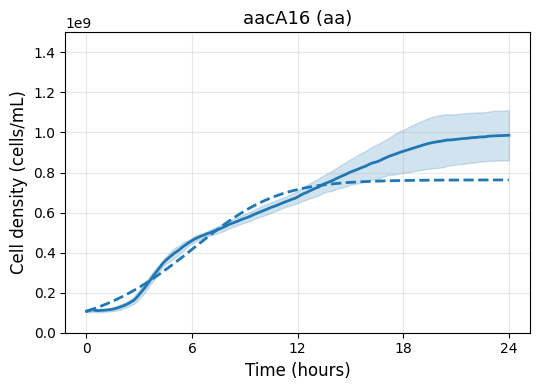

Saved fit for aa/aacA16 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA17 / aa
Birth rate        : 0.1292
K                 : 0.0512
Consumption rate  : 2.2326e-09
SSE               : 3.906e+02
R²                : 0.9138


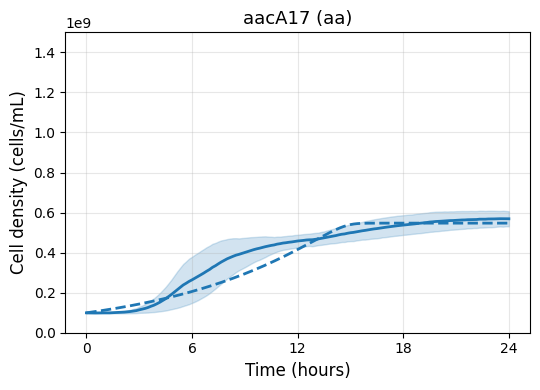

Saved fit for aa/aacA17 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA2 / aa
Birth rate        : 0.8600
K                 : 1.9992
Consumption rate  : 9.3134e-10
SSE               : 7.872e+02
R²                : 0.9816


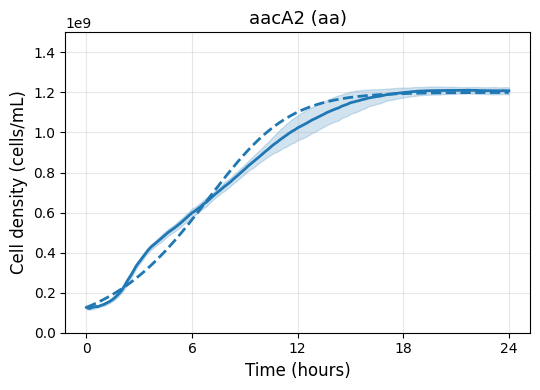

Saved fit for aa/aacA2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA27 / aa
Birth rate        : 0.7275
K                 : 2.0000
Consumption rate  : 1.2366e-09
SSE               : 3.854e+03
R²                : 0.9514


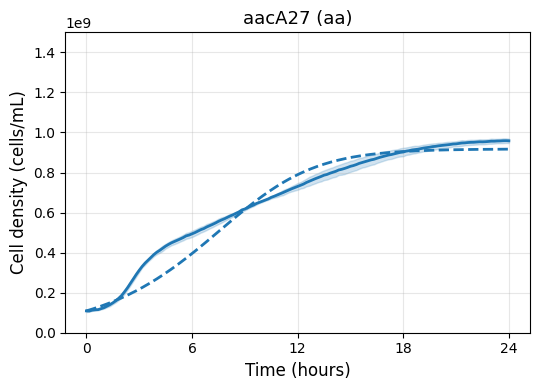

Saved fit for aa/aacA27 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA28 / aa
Birth rate        : 0.8597
K                 : 1.9991
Consumption rate  : 1.5359e-09
SSE               : 1.777e+03
R²                : 0.9075


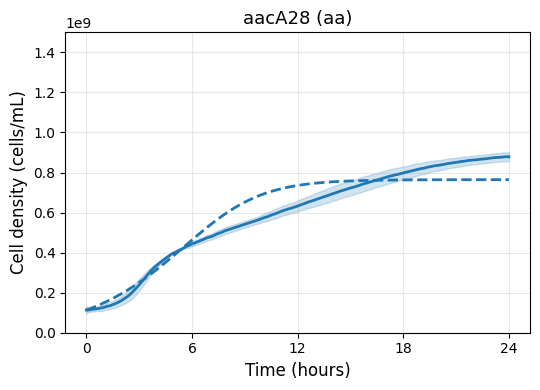

Saved fit for aa/aacA28 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA29 / aa
Birth rate        : 1.0164
K                 : 1.9993
Consumption rate  : 1.1559e-09
SSE               : 5.602e+02
R²                : 0.9599


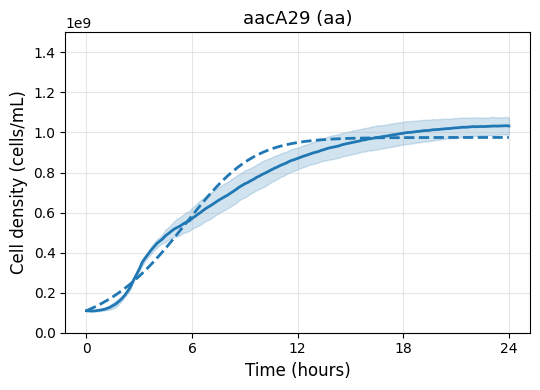

Saved fit for aa/aacA29 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA3 / aa
Birth rate        : 0.7525
K                 : 1.9993
Consumption rate  : 1.1543e-09
SSE               : 1.280e+02
R²                : 0.9614


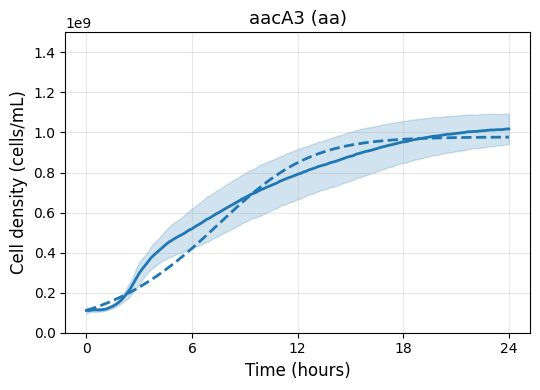

Saved fit for aa/aacA3 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA30 / aa
Birth rate        : 0.4125
K                 : 0.7310
Consumption rate  : 1.2218e-09
SSE               : 9.630e+02
R²                : 0.9481


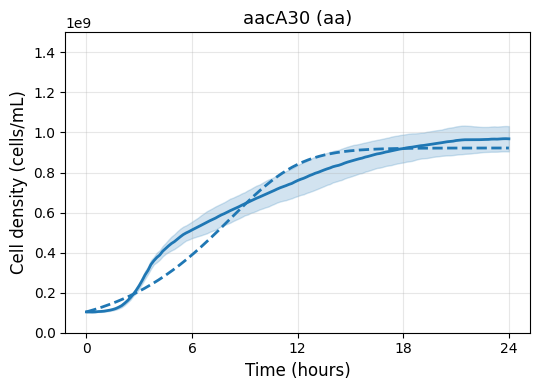

Saved fit for aa/aacA30 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA31 / aa
Birth rate        : 0.9057
K                 : 1.9997
Consumption rate  : 1.1458e-09
SSE               : 1.217e+03
R²                : 0.9755


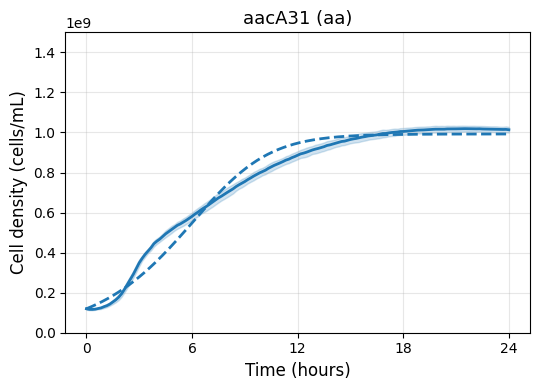

Saved fit for aa/aacA31 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA34 / aa
Birth rate        : 0.7634
K                 : 1.9998
Consumption rate  : 1.0432e-09
SSE               : 2.246e+02
R²                : 0.9740


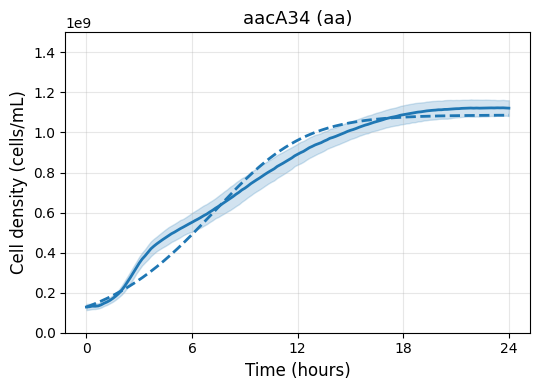

Saved fit for aa/aacA34 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA35 / aa
Birth rate        : 0.4624
K                 : 0.7217
Consumption rate  : 1.2196e-09
SSE               : 3.995e+02
R²                : 0.9444


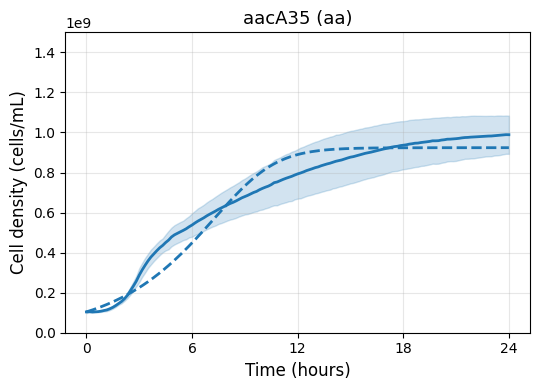

Saved fit for aa/aacA35 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA37 / aa
Birth rate        : 0.8286
K                 : 1.9998
Consumption rate  : 9.3670e-10
SSE               : 1.192e+02
R²                : 0.9743


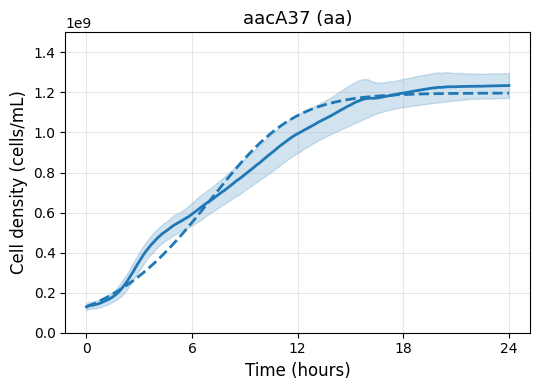

Saved fit for aa/aacA37 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA38 / aa
Birth rate        : 0.8650
K                 : 2.0000
Consumption rate  : 1.1192e-09
SSE               : 9.003e+02
R²                : 0.9489


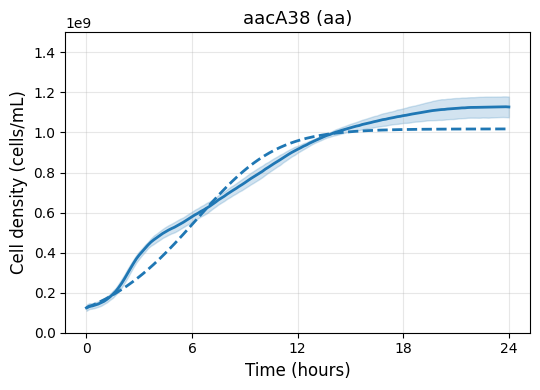

Saved fit for aa/aacA38 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA4 / aa
Birth rate        : 0.8326
K                 : 1.9993
Consumption rate  : 1.0877e-09
SSE               : 1.932e+02
R²                : 0.9647


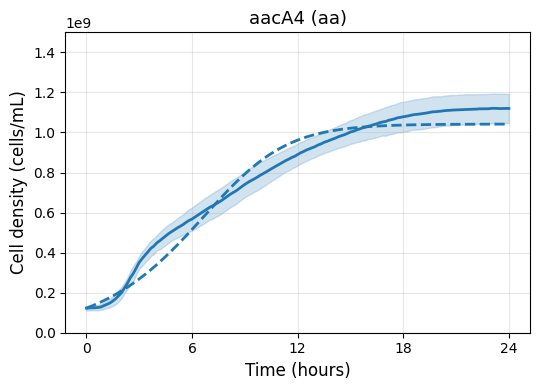

Saved fit for aa/aacA4 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA42 / aa
Birth rate        : 0.7806
K                 : 1.9977
Consumption rate  : 1.2811e-09
SSE               : 1.645e+03
R²                : 0.9526


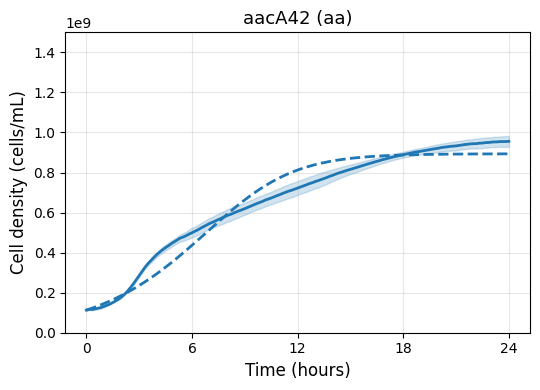

Saved fit for aa/aacA42 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA43 / aa
Birth rate        : 0.1709
K                 : 0.0699
Consumption rate  : 1.6465e-09
SSE               : 2.127e+03
R²                : 0.9356


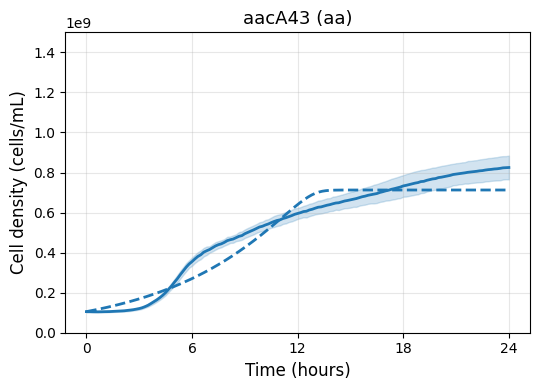

Saved fit for aa/aacA43 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA45 / aa
Birth rate        : 0.3749
K                 : 0.4453
Consumption rate  : 1.3728e-09
SSE               : 4.128e+03
R²                : 0.9068


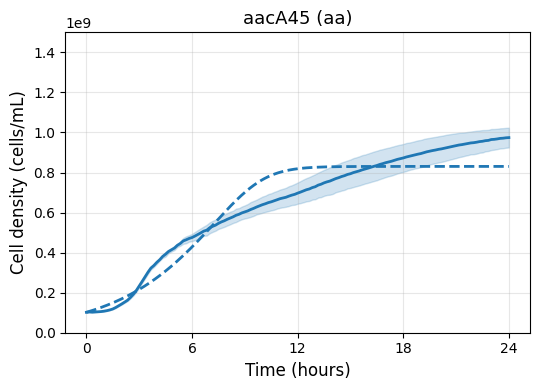

Saved fit for aa/aacA45 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA47 / aa
Birth rate        : 0.4372
K                 : 1.1504
Consumption rate  : 1.1663e-09
SSE               : 4.597e+03
R²                : 0.9288


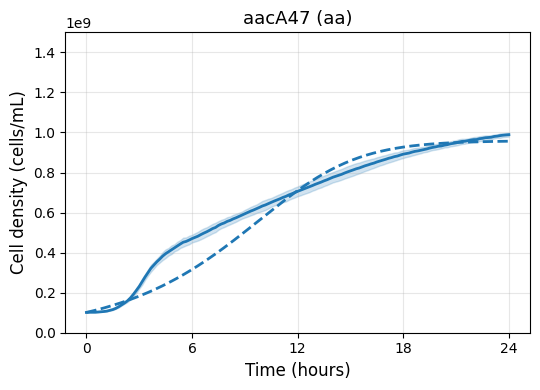

Saved fit for aa/aacA47 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA48 / aa
Birth rate        : 0.4587
K                 : 0.9938
Consumption rate  : 1.1938e-09
SSE               : 9.191e+02
R²                : 0.9226


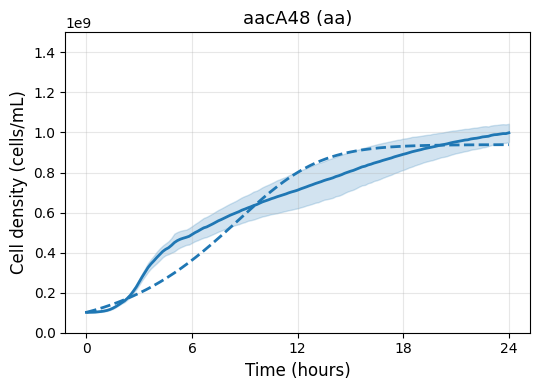

Saved fit for aa/aacA48 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA49 / aa
Birth rate        : 0.3731
K                 : 0.9277
Consumption rate  : 1.3508e-09
SSE               : 7.807e+03
R²                : 0.9589


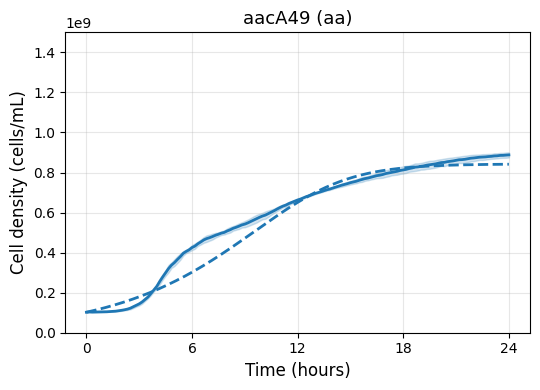

Saved fit for aa/aacA49 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA50 / aa
Birth rate        : 0.8023
K                 : 1.9996
Consumption rate  : 1.1371e-09
SSE               : 4.322e+02
R²                : 0.9517


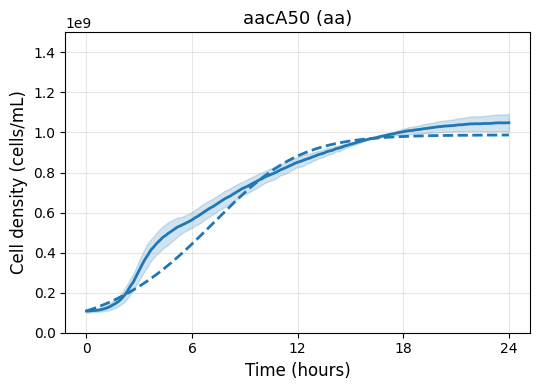

Saved fit for aa/aacA50 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA51 / aa
Birth rate        : 0.7240
K                 : 1.9905
Consumption rate  : 1.1543e-09
SSE               : 1.227e+03
R²                : 0.9747


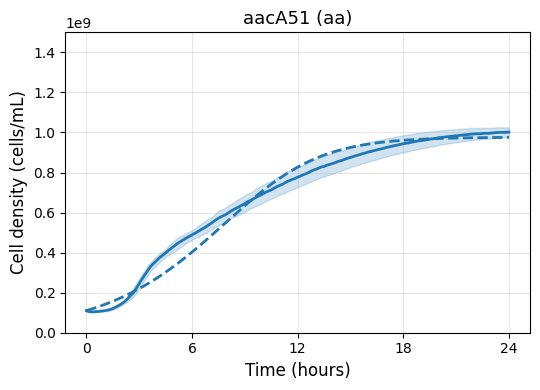

Saved fit for aa/aacA51 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA52 / aa
Birth rate        : 0.7699
K                 : 1.9991
Consumption rate  : 1.2294e-09
SSE               : 1.213e+03
R²                : 0.9547


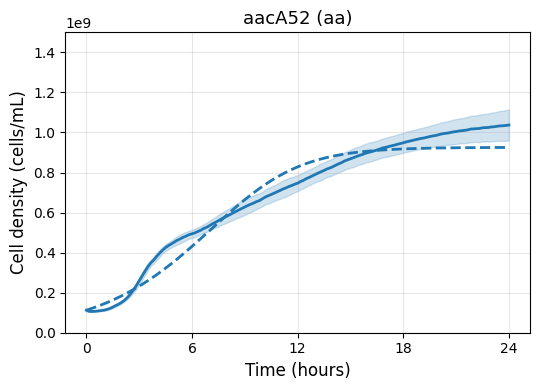

Saved fit for aa/aacA52 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA54 / aa
Birth rate        : 0.4017
K                 : 0.5344
Consumption rate  : 1.4012e-09
SSE               : 2.124e+03
R²                : 0.9023


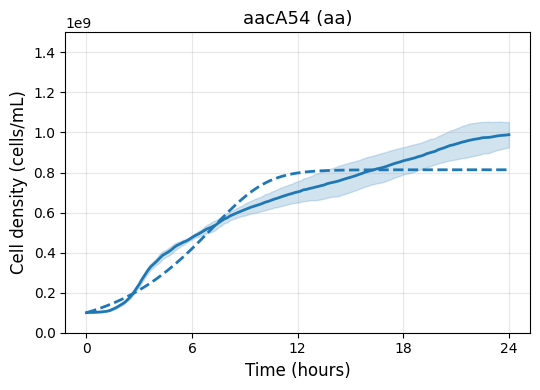

Saved fit for aa/aacA54 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA56 / aa
Birth rate        : 0.1000
K                 : 1.9979
Consumption rate  : 1.0335e-10
SSE               : 1.907e+04
R²                : -1.0643


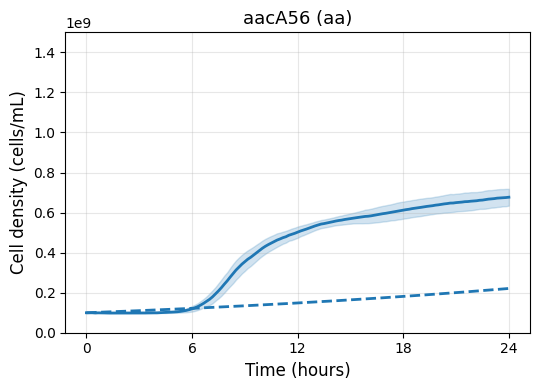

Saved fit for aa/aacA56 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA59 / aa
Birth rate        : 0.2268
K                 : 0.3729
Consumption rate  : 1.5260e-09
SSE               : 1.676e+02
R²                : 0.9411


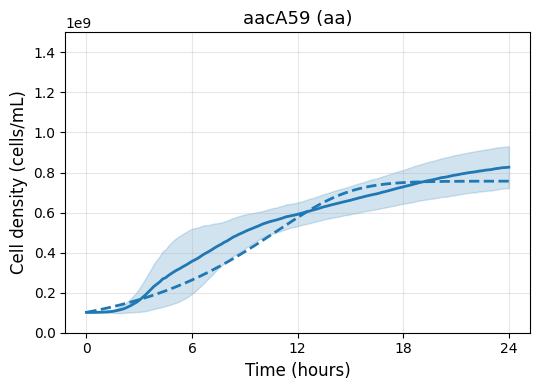

Saved fit for aa/aacA59 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA61 / aa
Birth rate        : 0.4095
K                 : 0.5593
Consumption rate  : 1.8789e-09
SSE               : 5.429e+03
R²                : 0.8460


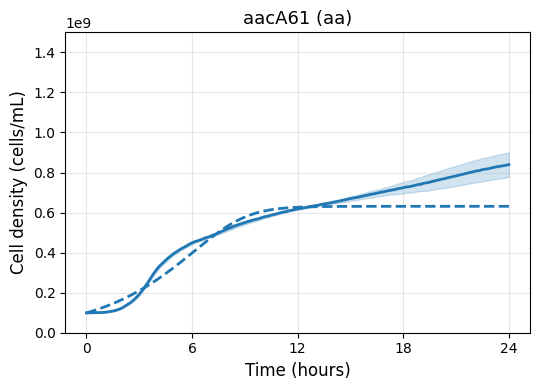

Saved fit for aa/aacA61 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA64 / aa
Birth rate        : 0.9009
K                 : 1.9997
Consumption rate  : 1.0413e-09
SSE               : 1.149e+02
R²                : 0.9796


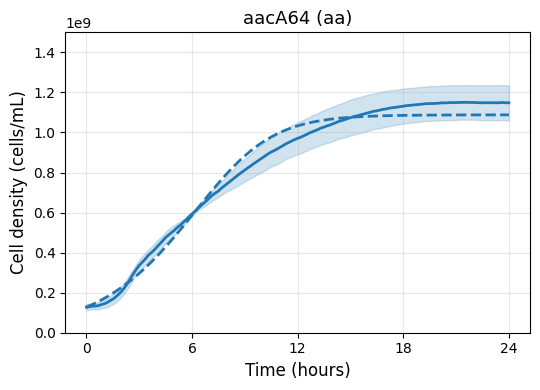

Saved fit for aa/aacA64 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA7 / aa
Birth rate        : 0.2560
K                 : 0.3600
Consumption rate  : 1.2682e-09
SSE               : 5.358e+02
R²                : 0.9504


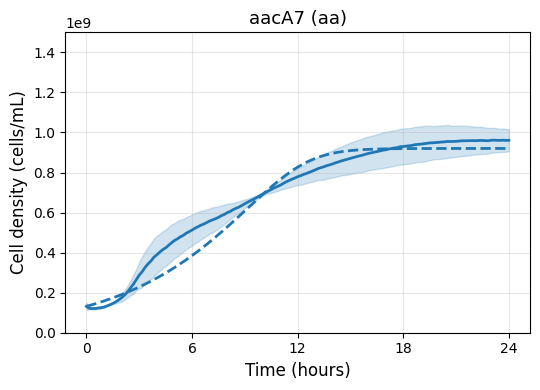

Saved fit for aa/aacA7 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacA8 / aa
Birth rate        : 0.7856
K                 : 1.9994
Consumption rate  : 1.0079e-09
SSE               : 1.106e+02
R²                : 0.9901


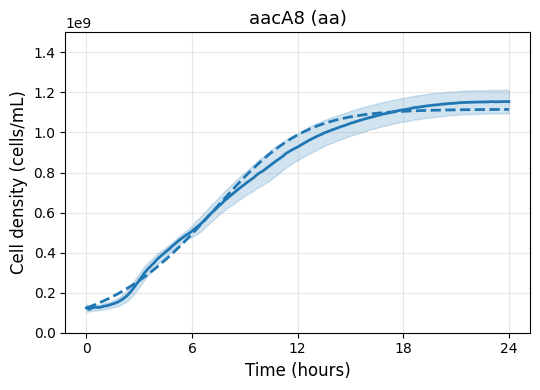

Saved fit for aa/aacA8 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacAX / aa
Birth rate        : 0.8569
K                 : 1.9963
Consumption rate  : 1.0084e-09
SSE               : 7.985e+01
R²                : 0.9891


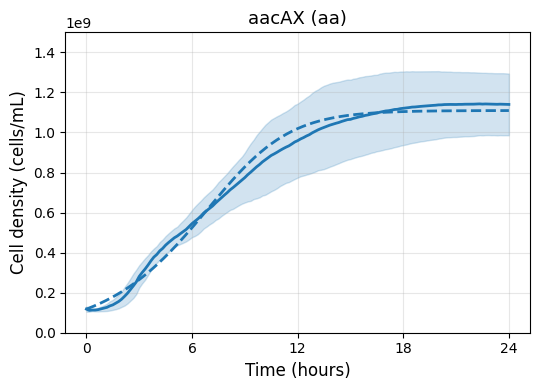

Saved fit for aa/aacAX to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC1 / aa
Birth rate        : 1.0087
K                 : 1.9999
Consumption rate  : 1.1740e-09
SSE               : 1.422e+03
R²                : 0.9159


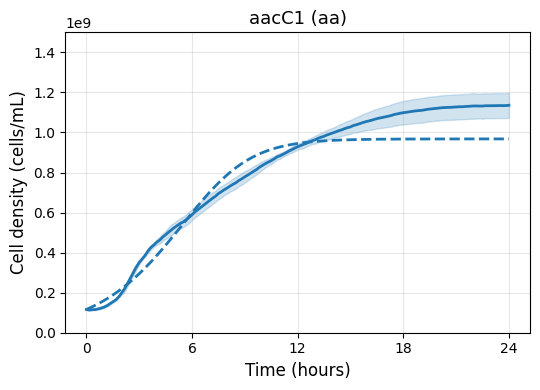

Saved fit for aa/aacC1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC11 / aa
Birth rate        : 0.9800
K                 : 1.9987
Consumption rate  : 1.3239e-09
SSE               : 2.179e+02
R²                : 0.9030


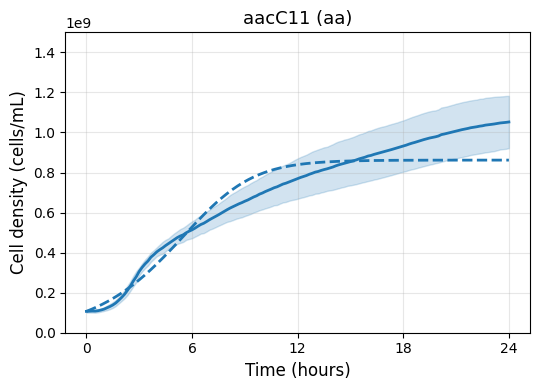

Saved fit for aa/aacC11 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC13 / aa
Birth rate        : 0.6381
K                 : 1.9999
Consumption rate  : 1.6252e-09
SSE               : 6.698e+02
R²                : 0.9394


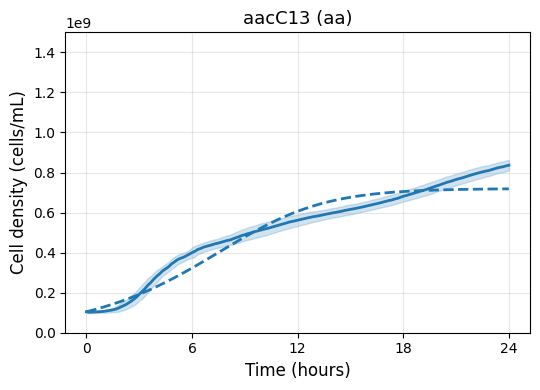

Saved fit for aa/aacC13 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC2 / aa
Birth rate        : 0.9215
K                 : 1.9981
Consumption rate  : 1.0201e-09
SSE               : 2.646e+02
R²                : 0.9609


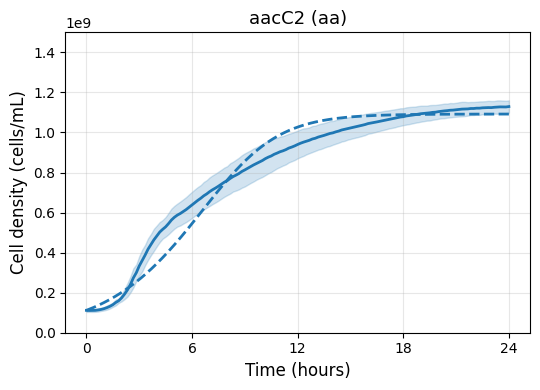

Saved fit for aa/aacC2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC3 / aa
Birth rate        : 0.8796
K                 : 1.9990
Consumption rate  : 1.1559e-09
SSE               : 2.292e+02
R²                : 0.9555


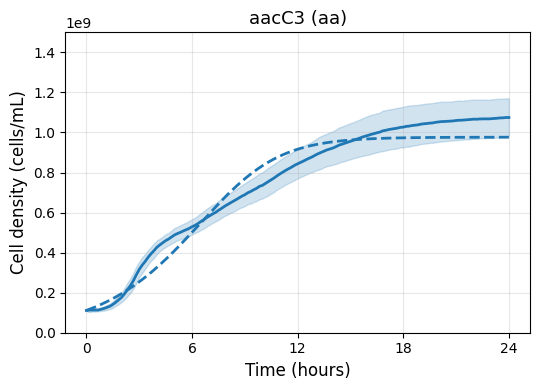

Saved fit for aa/aacC3 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC4 / aa
Birth rate        : 0.4183
K                 : 0.6913
Consumption rate  : 1.1086e-09
SSE               : 1.772e+02
R²                : 0.9483


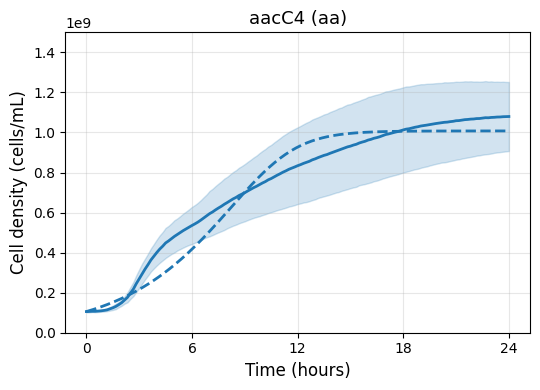

Saved fit for aa/aacC4 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC5 / aa
Birth rate        : 0.6636
K                 : 1.4565
Consumption rate  : 1.2426e-09
SSE               : 2.463e+03
R²                : 0.9615


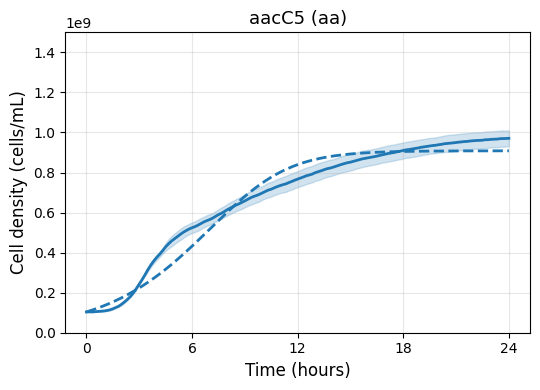

Saved fit for aa/aacC5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aacC6 / aa
Birth rate        : 0.7589
K                 : 1.9979
Consumption rate  : 1.0823e-09
SSE               : 9.677e+02
R²                : 0.9558


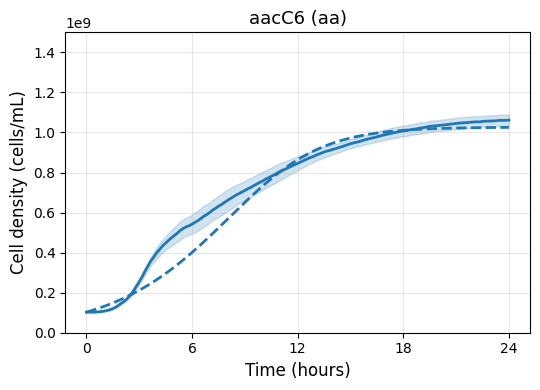

Saved fit for aa/aacC6 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA1 / aa
Birth rate        : 0.1430
K                 : 0.0528
Consumption rate  : 1.5284e-09
SSE               : 7.702e+03
R²                : 0.7291


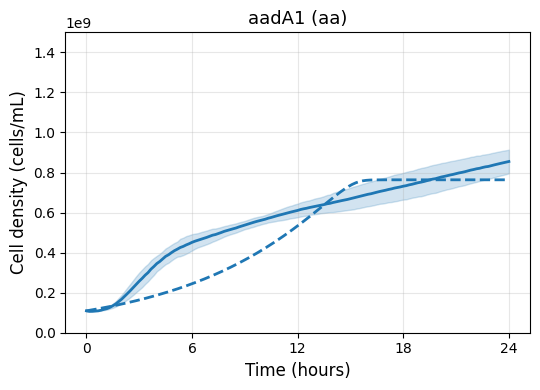

Saved fit for aa/aadA1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA10 / aa
Birth rate        : 0.9080
K                 : 1.9997
Consumption rate  : 1.1457e-09
SSE               : 2.792e+02
R²                : 0.9800


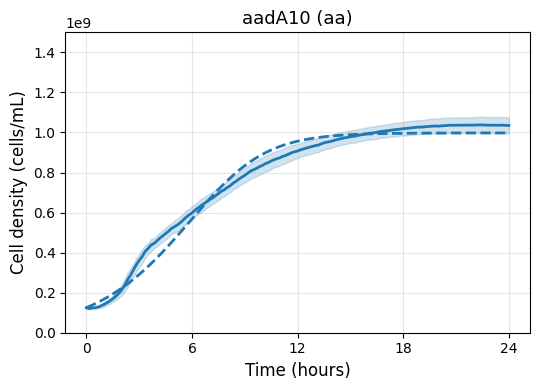

Saved fit for aa/aadA10 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA11 / aa
Birth rate        : 0.8558
K                 : 1.9999
Consumption rate  : 1.1459e-09
SSE               : 2.463e+02
R²                : 0.9721


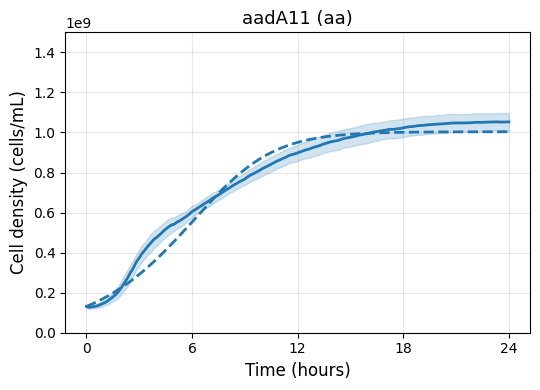

Saved fit for aa/aadA11 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA13 / aa
Birth rate        : 0.7680
K                 : 1.9996
Consumption rate  : 1.1141e-09
SSE               : 1.609e+02
R²                : 0.9650


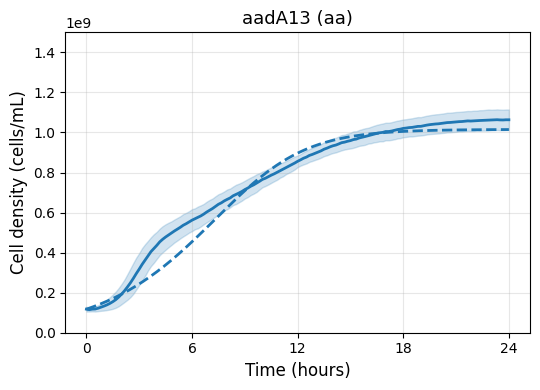

Saved fit for aa/aadA13 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA16 / aa
Birth rate        : 0.1352
K                 : 0.0500
Consumption rate  : 1.1044e-09
SSE               : 1.965e+04
R²                : 0.3280


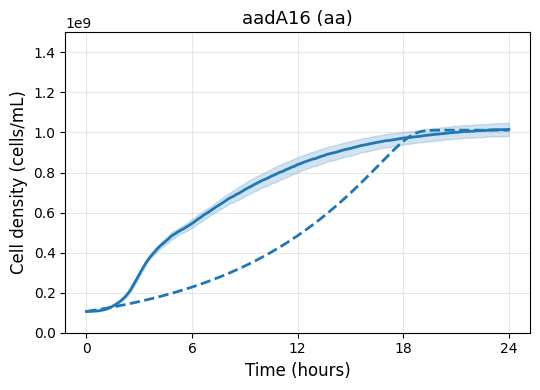

Saved fit for aa/aadA16 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA2 / aa
Birth rate        : 0.8302
K                 : 1.9996
Consumption rate  : 1.3199e-09
SSE               : 1.981e+03
R²                : 0.9355


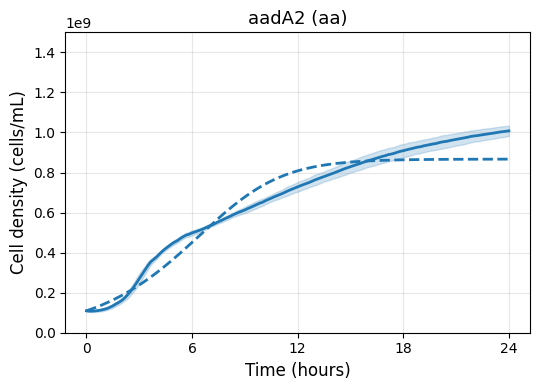

Saved fit for aa/aadA2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA24 / aa
Birth rate        : 0.7720
K                 : 1.9765
Consumption rate  : 1.6714e-09
SSE               : 2.939e+02
R²                : 0.9813


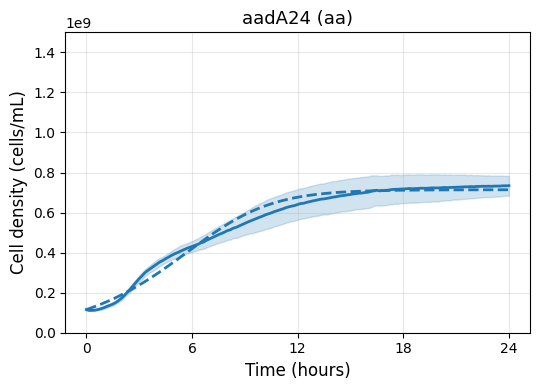

Saved fit for aa/aadA24 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA28 / aa
Birth rate        : 0.8758
K                 : 1.9982
Consumption rate  : 1.3244e-09
SSE               : 1.571e+02
R²                : 0.9367


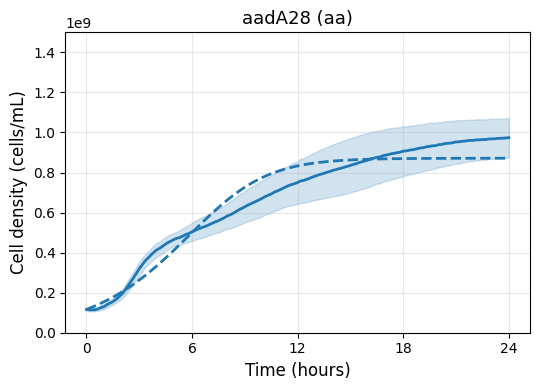

Saved fit for aa/aadA28 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA29 / aa
Birth rate        : 0.7531
K                 : 2.0000
Consumption rate  : 1.1336e-09
SSE               : 4.830e+02
R²                : 0.9588


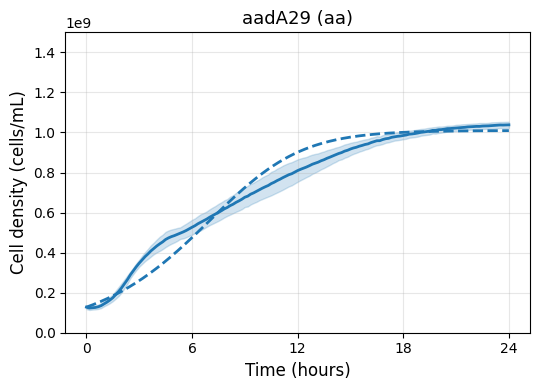

Saved fit for aa/aadA29 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA34 / aa
Birth rate        : 0.9010
K                 : 1.9990
Consumption rate  : 1.3400e-09
SSE               : 2.752e+03
R²                : 0.9143


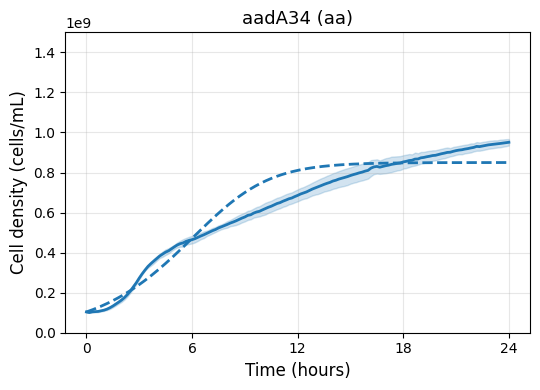

Saved fit for aa/aadA34 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA4 / aa
Birth rate        : 0.8264
K                 : 1.9992
Consumption rate  : 1.0390e-09
SSE               : 1.544e+03
R²                : 0.9564


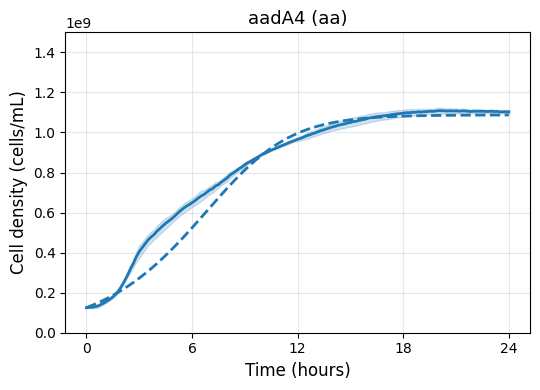

Saved fit for aa/aadA4 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA5 / aa
Birth rate        : 1.0043
K                 : 1.9995
Consumption rate  : 1.0294e-09
SSE               : 6.804e+02
R²                : 0.9698


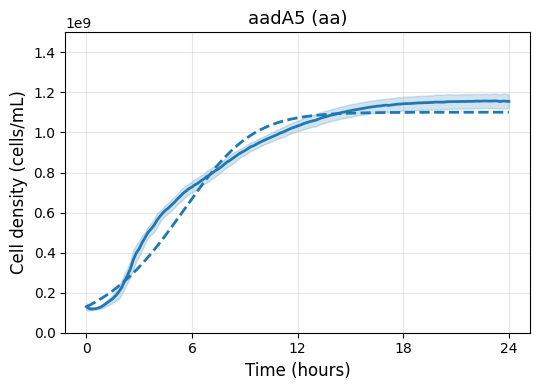

Saved fit for aa/aadA5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA6 / aa
Birth rate        : 0.9769
K                 : 2.0000
Consumption rate  : 1.0023e-09
SSE               : 5.965e+02
R²                : 0.9662


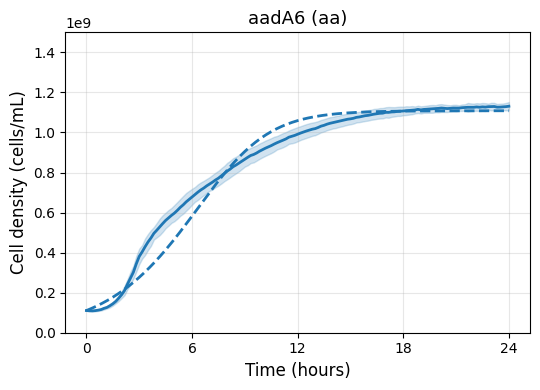

Saved fit for aa/aadA6 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadA7 / aa
Birth rate        : 0.8974
K                 : 1.9999
Consumption rate  : 1.0437e-09
SSE               : 2.227e+02
R²                : 0.9674


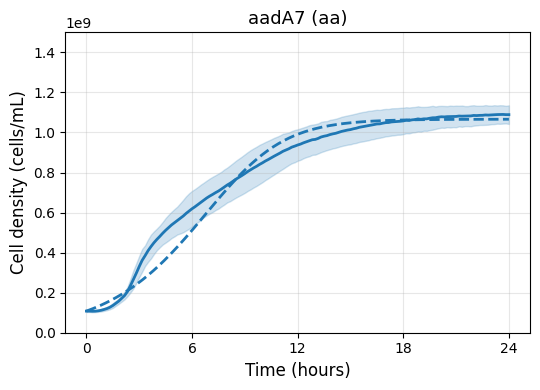

Saved fit for aa/aadA7 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aadB / aa
Birth rate        : 0.2919
K                 : 0.4983
Consumption rate  : 1.3299e-09
SSE               : 3.600e+03
R²                : 0.9197


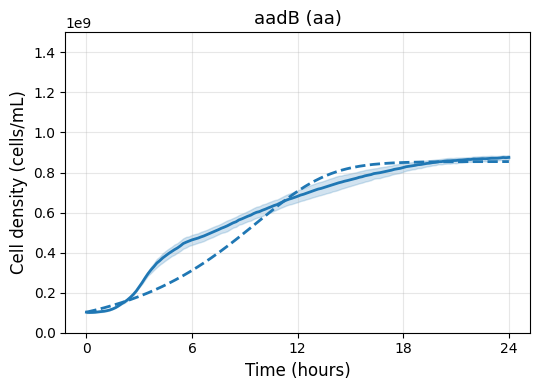

Saved fit for aa/aadB to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aphA15 / aa
Birth rate        : 1.0327
K                 : 1.9996
Consumption rate  : 1.1282e-09
SSE               : 2.831e+03
R²                : 0.9651


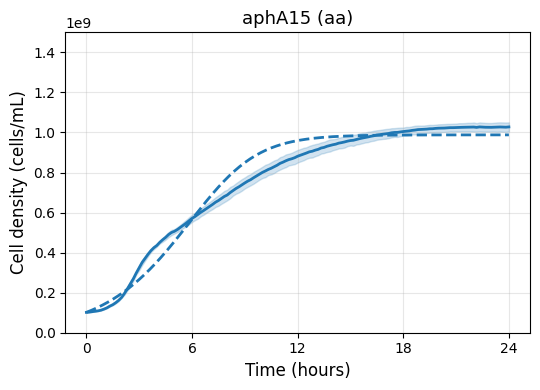

Saved fit for aa/aphA15 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : aphA16 / aa
Birth rate        : 0.6742
K                 : 2.0000
Consumption rate  : 1.2018e-09
SSE               : 1.287e+03
R²                : 0.9855


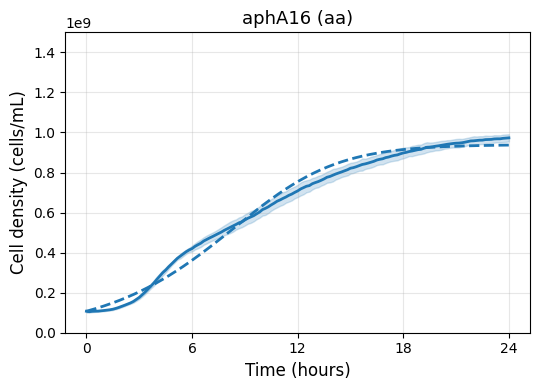

Saved fit for aa/aphA16 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : pMBA / aa
Birth rate        : 0.9423
K                 : 1.9976
Consumption rate  : 1.0664e-09
SSE               : 4.432e+02
R²                : 0.9694


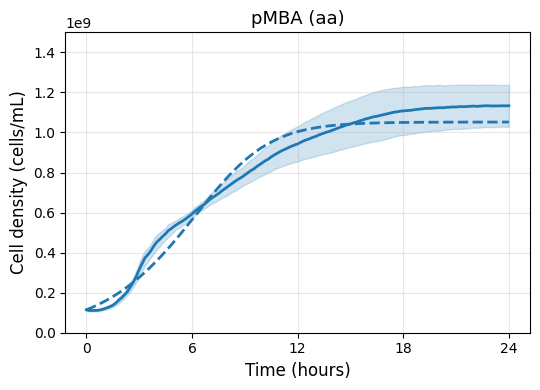

Saved fit for aa/pMBA to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : sat2 / aa
Birth rate        : 0.7808
K                 : 1.9995
Consumption rate  : 1.2687e-09
SSE               : 1.010e+03
R²                : 0.9618


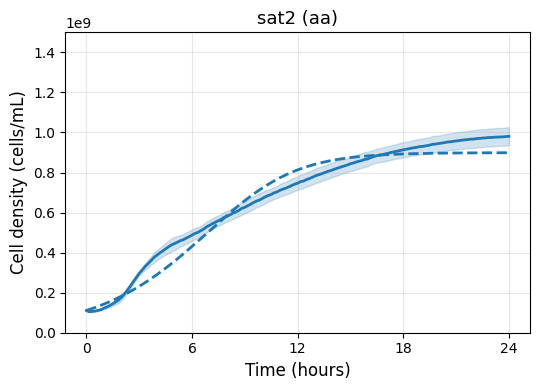

Saved fit for aa/sat2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : BEL1 / bla
Birth rate        : 1.1839
K                 : 1.9992
Consumption rate  : 2.1078e-09
SSE               : 5.510e+03
R²                : 0.0463


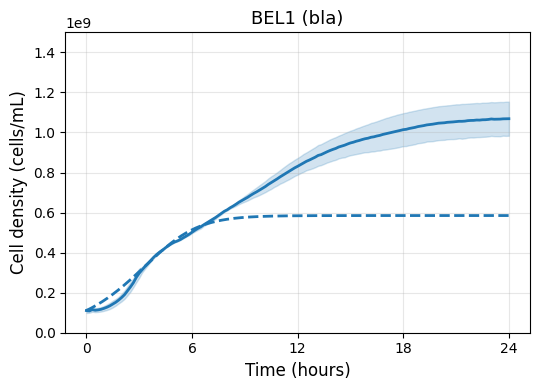

Saved fit for bla/BEL1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : GES1 / bla
Birth rate        : 0.7924
K                 : 1.9999
Consumption rate  : 1.2550e-09
SSE               : 4.862e+02
R²                : 0.9470


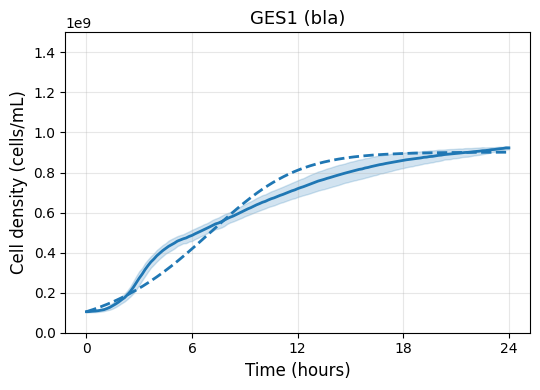

Saved fit for bla/GES1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : IMP2 / bla
Birth rate        : 0.1913
K                 : 0.1038
Consumption rate  : 1.7687e-09
SSE               : 3.865e+03
R²                : 0.8980


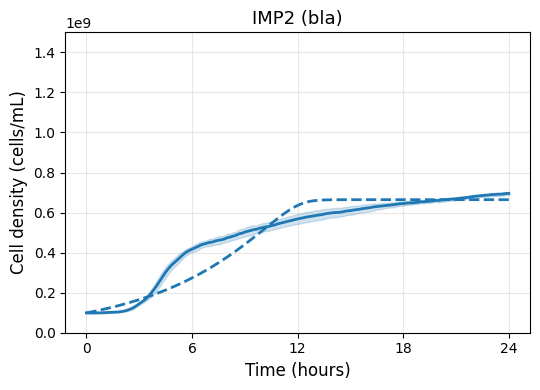

Saved fit for bla/IMP2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : IMP31 / bla
Birth rate        : 0.3437
K                 : 0.6509
Consumption rate  : 1.7581e-09
SSE               : 5.542e+02
R²                : 0.9513


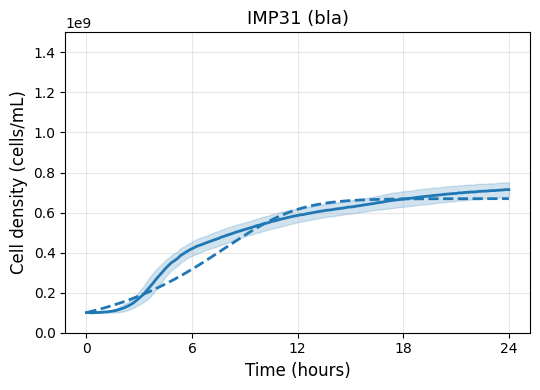

Saved fit for bla/IMP31 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA1 / bla
Birth rate        : 0.6634
K                 : 1.9992
Consumption rate  : 1.3798e-09
SSE               : 3.270e+02
R²                : 0.9382


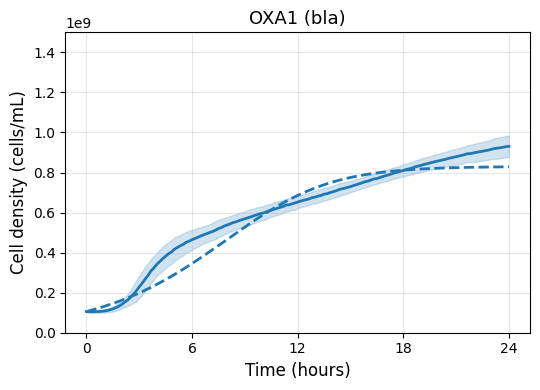

Saved fit for bla/OXA1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA10 / bla
Birth rate        : 0.9811
K                 : 1.9959
Consumption rate  : 1.3076e-09
SSE               : 1.150e+03
R²                : 0.9109


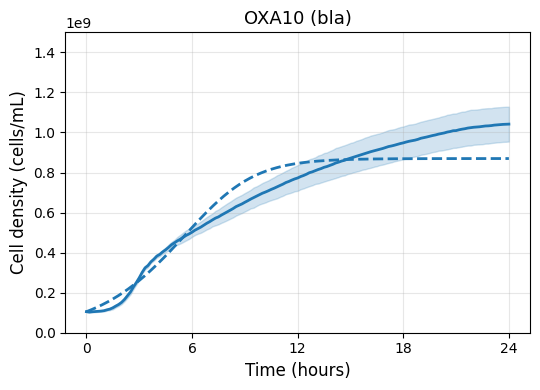

Saved fit for bla/OXA10 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA118 / bla
Birth rate        : 0.6201
K                 : 1.9994
Consumption rate  : 1.9079e-09
SSE               : 2.622e+02
R²                : 0.9035


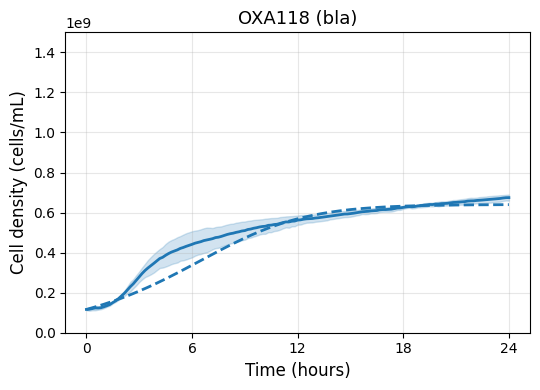

Saved fit for bla/OXA118 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA129 / bla
Birth rate        : 0.5758
K                 : 1.9999
Consumption rate  : 2.4021e-09
SSE               : 4.785e+02
R²                : 0.9525


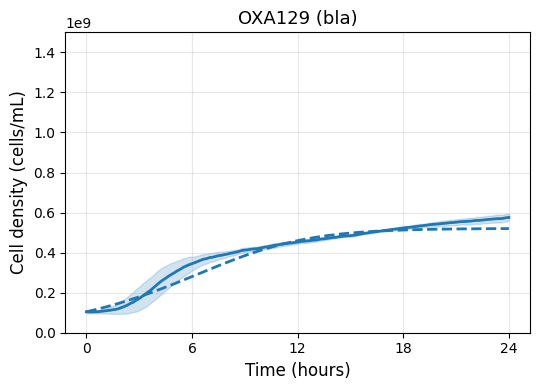

Saved fit for bla/OXA129 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA198 / bla
Birth rate        : 0.5739
K                 : 1.3828
Consumption rate  : 1.1486e-09
SSE               : 9.435e+03
R²                : 0.9675


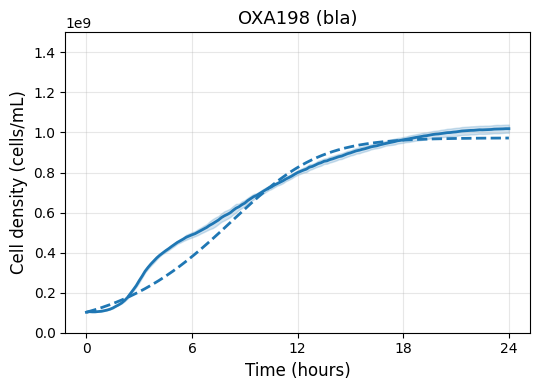

Saved fit for bla/OXA198 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA2 / bla
Birth rate        : 0.6709
K                 : 1.9983
Consumption rate  : 1.8526e-09
SSE               : 1.932e+02
R²                : 0.9617


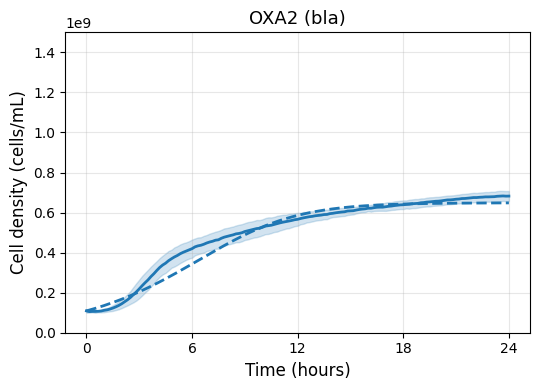

Saved fit for bla/OXA2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA20 / bla
Birth rate        : 0.4038
K                 : 1.9985
Consumption rate  : 2.1379e-09
SSE               : 2.065e+00
R²                : 0.9883


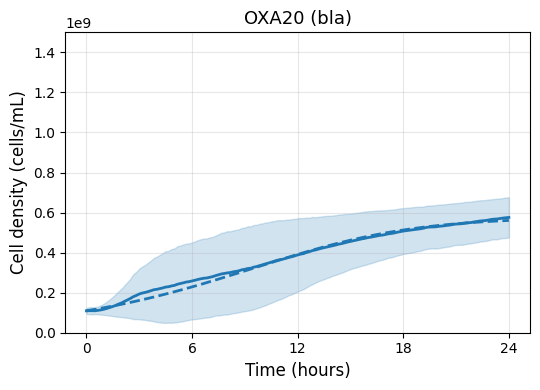

Saved fit for bla/OXA20 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA21 / bla
Birth rate        : 0.9206
K                 : 1.9952
Consumption rate  : 4.8744e-09
SSE               : 7.635e+02
R²                : 0.6380


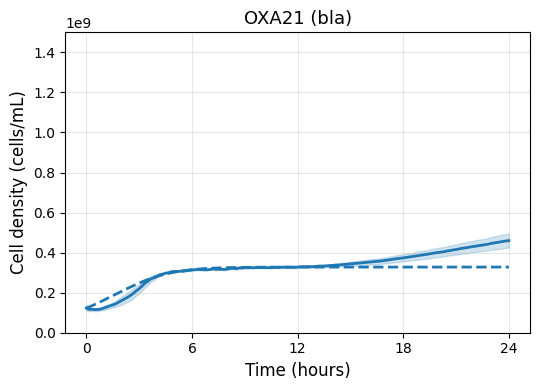

Saved fit for bla/OXA21 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA46 / bla
Birth rate        : 0.1596
K                 : 0.0508
Consumption rate  : 2.8489e-09
SSE               : 1.204e+02
R²                : 0.9340


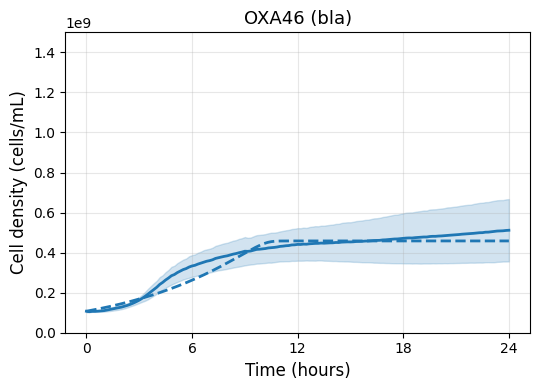

Saved fit for bla/OXA46 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA5 / bla
Birth rate        : 0.8007
K                 : 1.9998
Consumption rate  : 2.1132e-09
SSE               : 6.804e+01
R²                : 0.9552


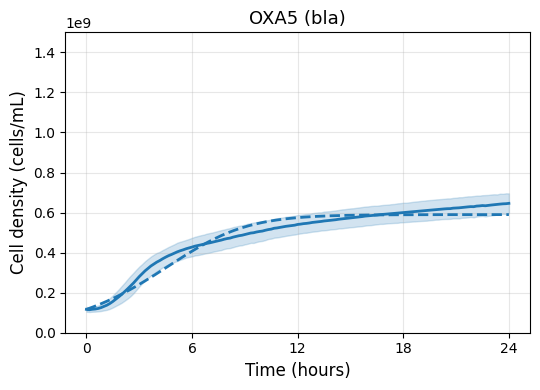

Saved fit for bla/OXA5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : OXA9 / bla
Birth rate        : 0.4999
K                 : 0.8747
Consumption rate  : 2.1335e-09
SSE               : 3.820e+02
R²                : 0.9720


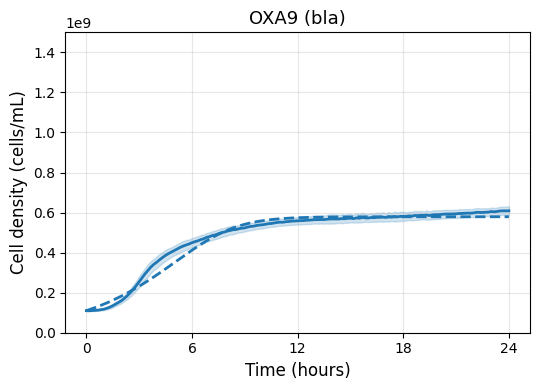

Saved fit for bla/OXA9 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : PBL1 / bla
Birth rate        : 0.8254
K                 : 2.0000
Consumption rate  : 1.1513e-09
SSE               : 3.160e+03
R²                : 0.9507


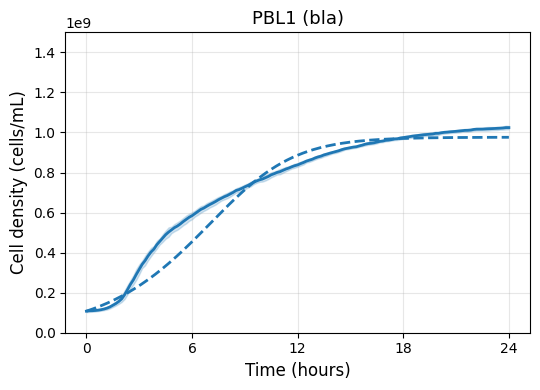

Saved fit for bla/PBL1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : VIM1 / bla
Birth rate        : 0.1450
K                 : 0.0502
Consumption rate  : 1.2954e-09
SSE               : 1.702e+03
R²                : 0.7768


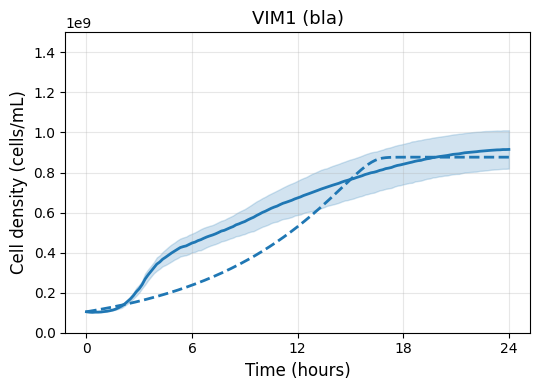

Saved fit for bla/VIM1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : VIM2 / bla
Birth rate        : 0.6810
K                 : 1.9996
Consumption rate  : 2.1227e-09
SSE               : 6.760e+01
R²                : 0.9658


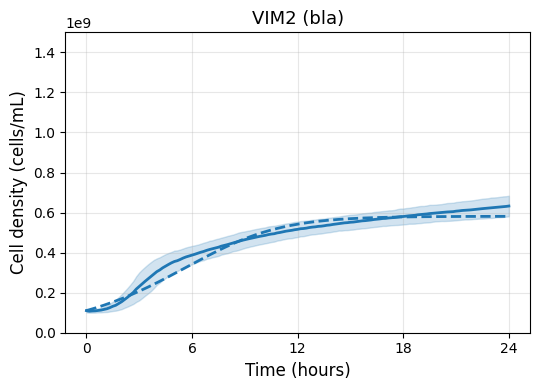

Saved fit for bla/VIM2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : VIM7 / bla
Birth rate        : 0.8213
K                 : 1.9993
Consumption rate  : 1.0178e-09
SSE               : 5.230e+02
R²                : 0.9592


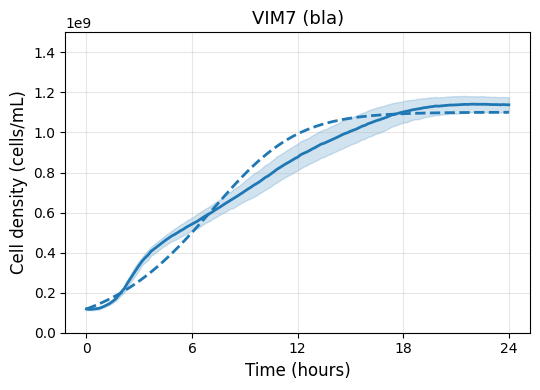

Saved fit for bla/VIM7 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : pMBA / bla
Birth rate        : 0.9418
K                 : 1.9985
Consumption rate  : 1.0657e-09
SSE               : 4.432e+02
R²                : 0.9696


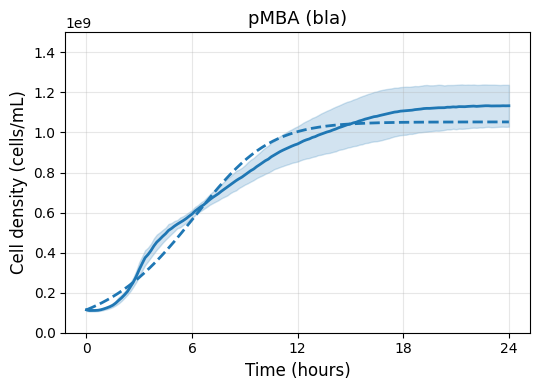

Saved fit for bla/pMBA to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA1 / dfr
Birth rate        : 0.1174
K                 : 0.0504
Consumption rate  : 1.1314e-09
SSE               : 1.306e+04
R²                : 0.4799


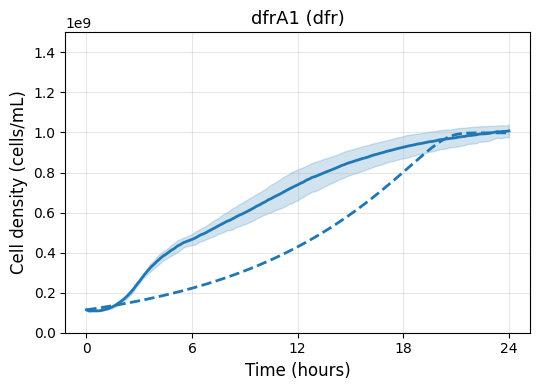

Saved fit for dfr/dfrA1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA12 / dfr
Birth rate        : 0.7217
K                 : 1.9965
Consumption rate  : 1.3104e-09
SSE               : 5.457e+02
R²                : 0.9550


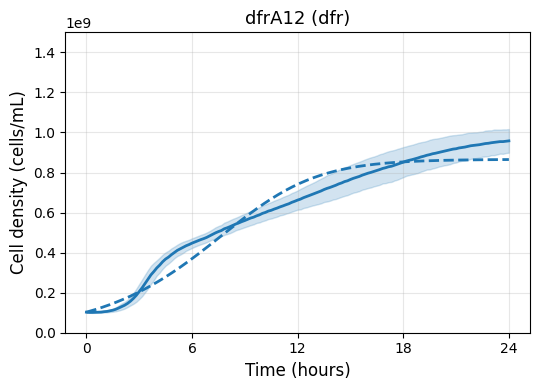

Saved fit for dfr/dfrA12 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA14 / dfr
Birth rate        : 0.2845
K                 : 0.3003
Consumption rate  : 1.8535e-09
SSE               : 6.006e+03
R²                : 0.8521


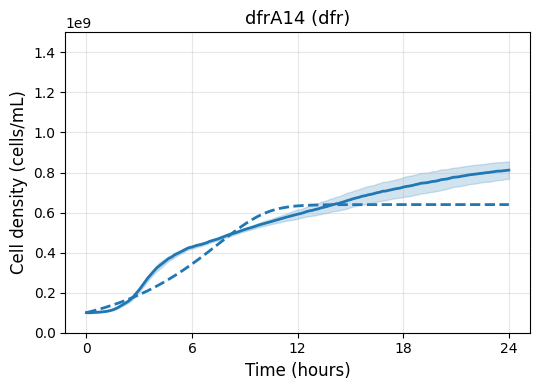

Saved fit for dfr/dfrA14 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA15 / dfr
Birth rate        : 0.6579
K                 : 1.9987
Consumption rate  : 1.6889e-09
SSE               : 2.551e+03
R²                : 0.8932


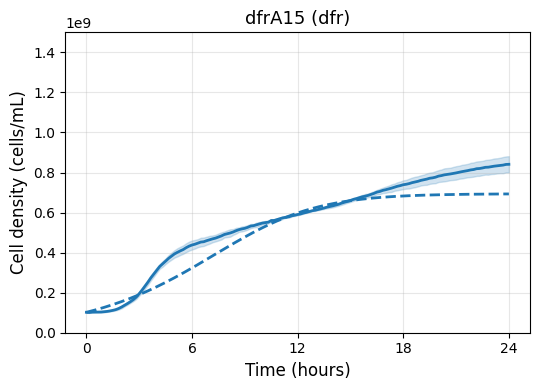

Saved fit for dfr/dfrA15 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA16 / dfr
Birth rate        : 0.9525
K                 : 1.9991
Consumption rate  : 1.4012e-09
SSE               : 3.444e+03
R²                : 0.9153


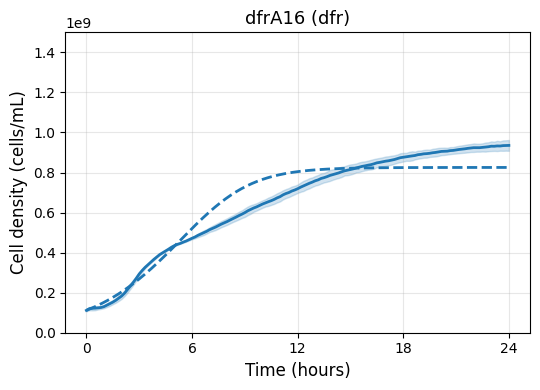

Saved fit for dfr/dfrA16 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA17 / dfr
Birth rate        : 0.8341
K                 : 1.9998
Consumption rate  : 1.4067e-09
SSE               : 1.334e+03
R²                : 0.9308


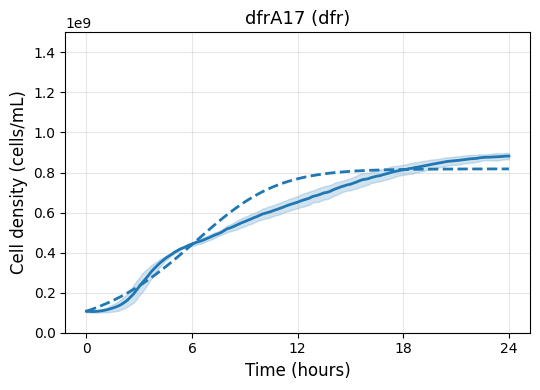

Saved fit for dfr/dfrA17 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA21 / dfr
Birth rate        : 0.8266
K                 : 1.9998
Consumption rate  : 1.2814e-09
SSE               : 2.531e+03
R²                : 0.9647


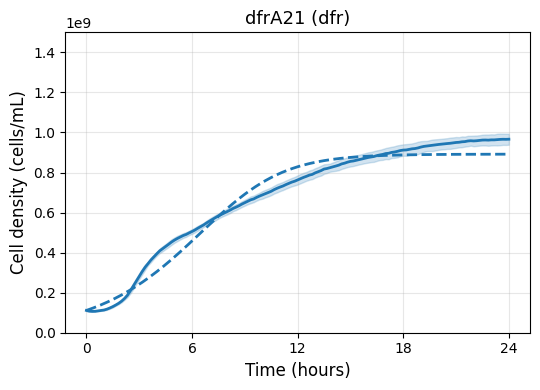

Saved fit for dfr/dfrA21 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA22 / dfr
Birth rate        : 0.9449
K                 : 1.9995
Consumption rate  : 1.3788e-09
SSE               : 1.570e+03
R²                : 0.8817


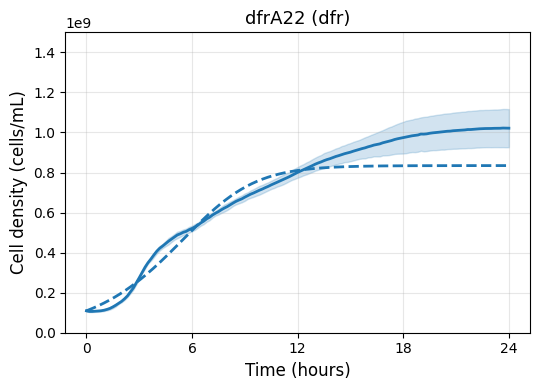

Saved fit for dfr/dfrA22 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA25 / dfr
Birth rate        : 0.9436
K                 : 1.9986
Consumption rate  : 1.1658e-09
SSE               : 1.954e+03
R²                : 0.9566


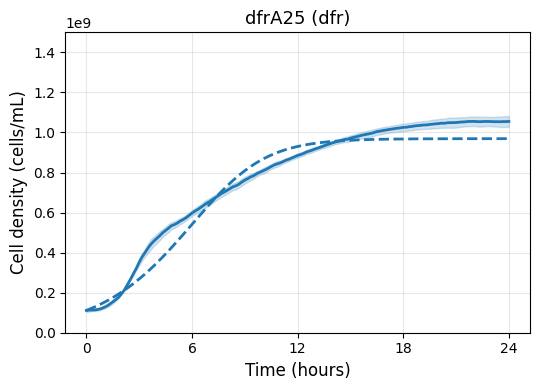

Saved fit for dfr/dfrA25 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA27 / dfr
Birth rate        : 0.8582
K                 : 1.9987
Consumption rate  : 1.2026e-09
SSE               : 8.077e+02
R²                : 0.9731


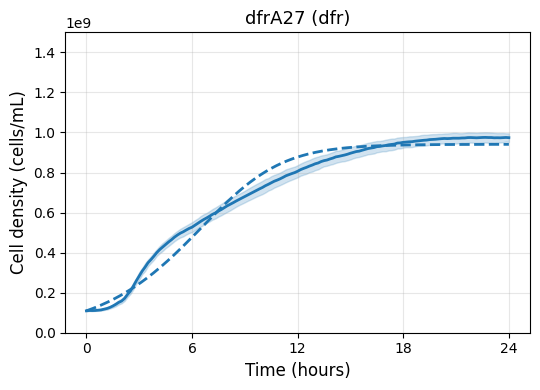

Saved fit for dfr/dfrA27 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA29 / dfr
Birth rate        : 0.1652
K                 : 0.0509
Consumption rate  : 1.1981e-09
SSE               : 3.458e+04
R²                : 0.8388


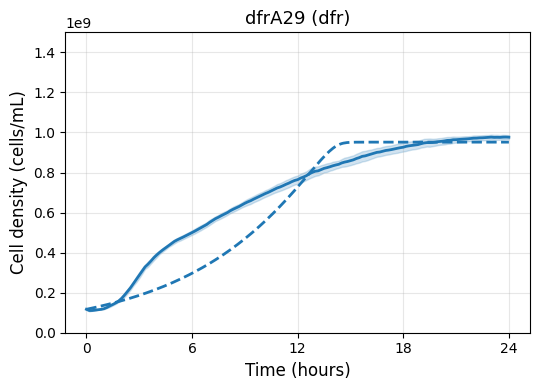

Saved fit for dfr/dfrA29 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA30 / dfr
Birth rate        : 0.9040
K                 : 1.9998
Consumption rate  : 1.4728e-09
SSE               : 6.116e+02
R²                : 0.7164


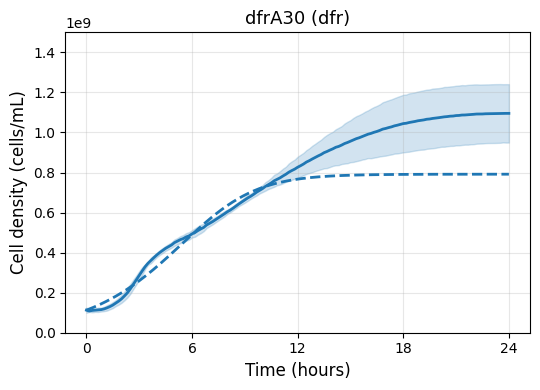

Saved fit for dfr/dfrA30 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA31 / dfr
Birth rate        : 0.7022
K                 : 1.9992
Consumption rate  : 1.3133e-09
SSE               : 4.724e+03
R²                : 0.9692


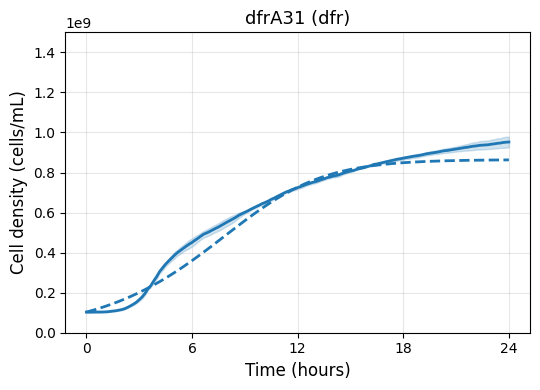

Saved fit for dfr/dfrA31 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA34 / dfr
Birth rate        : 0.9637
K                 : 1.9996
Consumption rate  : 1.3006e-09
SSE               : 4.252e+03
R²                : 0.9488


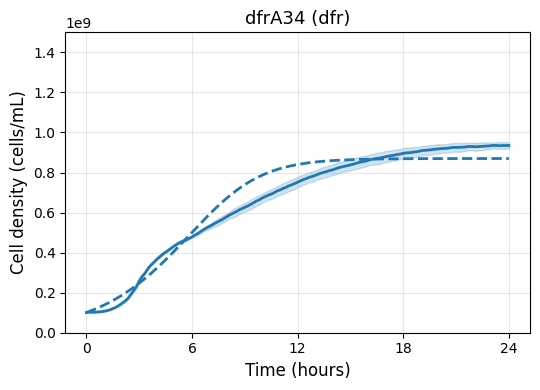

Saved fit for dfr/dfrA34 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA35 / dfr
Birth rate        : 0.1798
K                 : 0.0506
Consumption rate  : 1.3628e-09
SSE               : 4.197e+04
R²                : 0.8683


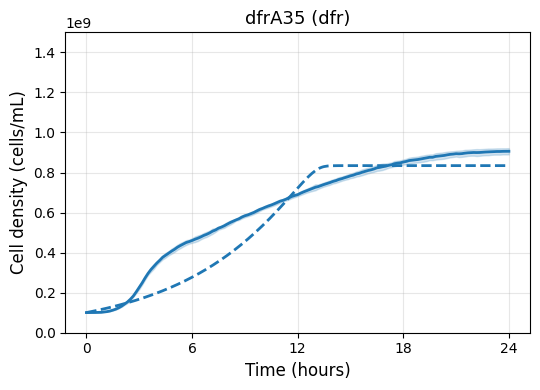

Saved fit for dfr/dfrA35 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA5 / dfr
Birth rate        : 0.6974
K                 : 1.9981
Consumption rate  : 1.2298e-09
SSE               : 5.777e+02
R²                : 0.9638


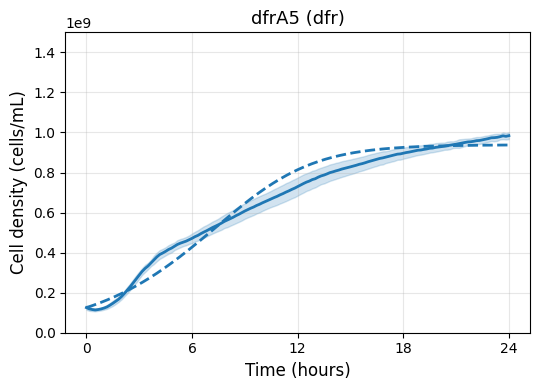

Saved fit for dfr/dfrA5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA6 / dfr
Birth rate        : 0.5589
K                 : 1.9998
Consumption rate  : 1.3638e-09
SSE               : 2.669e+01
R²                : 0.9425


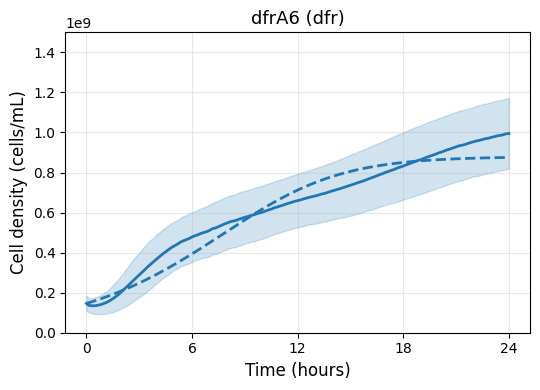

Saved fit for dfr/dfrA6 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrA7 / dfr
Birth rate        : 0.8146
K                 : 1.9993
Consumption rate  : 1.3840e-09
SSE               : 1.045e+03
R²                : 0.9690


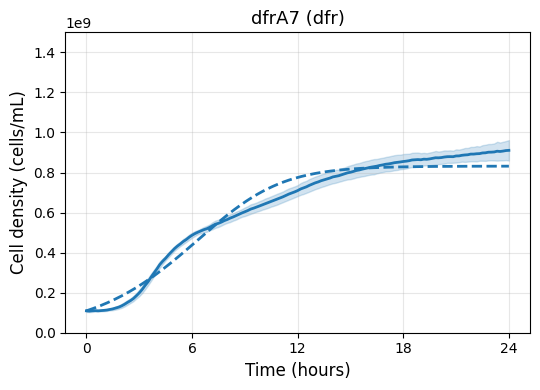

Saved fit for dfr/dfrA7 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB1 / dfr
Birth rate        : 0.9424
K                 : 1.9997
Consumption rate  : 1.3718e-09
SSE               : 6.352e+03
R²                : 0.9289


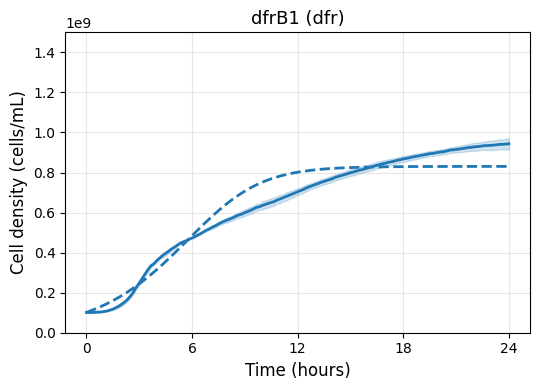

Saved fit for dfr/dfrB1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB2 / dfr
Birth rate        : 0.8016
K                 : 1.9998
Consumption rate  : 1.0353e-09
SSE               : 1.210e+03
R²                : 0.9751


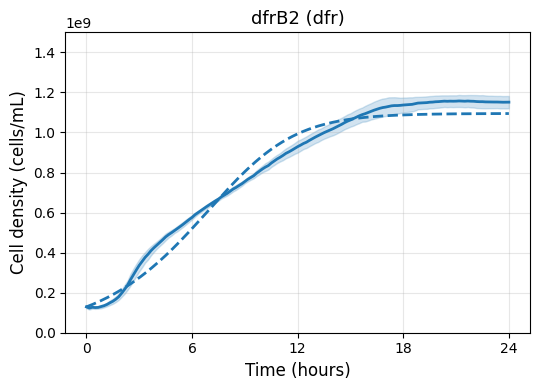

Saved fit for dfr/dfrB2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB3 / dfr
Birth rate        : 1.1470
K                 : 1.9993
Consumption rate  : 1.4942e-09
SSE               : 4.923e+02
R²                : 0.6558


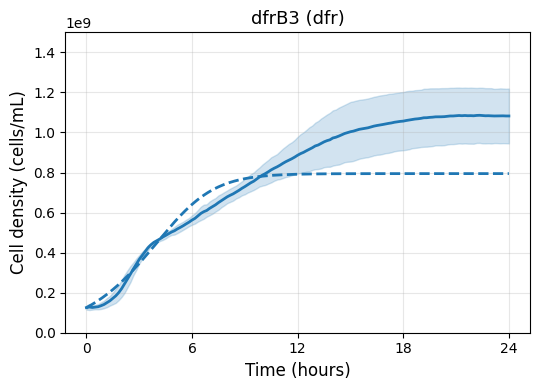

Saved fit for dfr/dfrB3 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB4 / dfr
Birth rate        : 0.7449
K                 : 1.9980
Consumption rate  : 1.3770e-09
SSE               : 1.813e+03
R²                : 0.9486


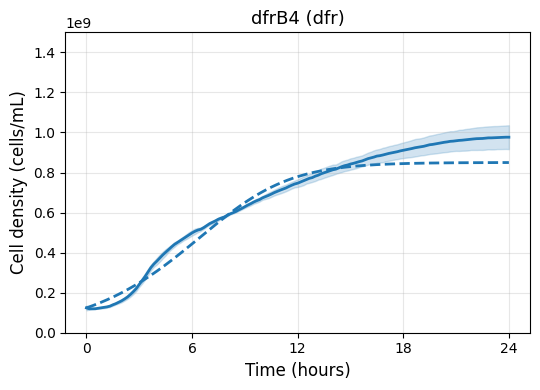

Saved fit for dfr/dfrB4 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB5 / dfr
Birth rate        : 0.6755
K                 : 1.9992
Consumption rate  : 1.1567e-09
SSE               : 5.055e+02
R²                : 0.9628


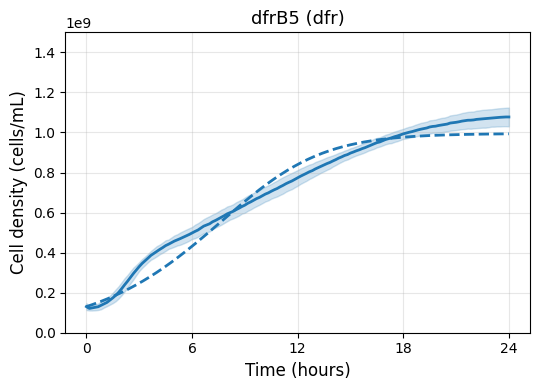

Saved fit for dfr/dfrB5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB6 / dfr
Birth rate        : 0.8945
K                 : 1.9993
Consumption rate  : 1.2684e-09
SSE               : 2.913e+02
R²                : 0.9490


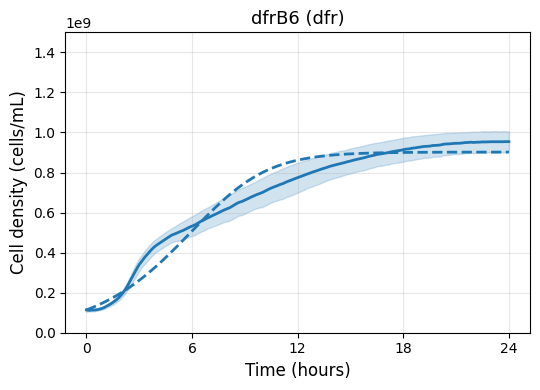

Saved fit for dfr/dfrB6 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB7 / dfr
Birth rate        : 0.8126
K                 : 1.9989
Consumption rate  : 1.2481e-09
SSE               : 1.607e+02
R²                : 0.9600


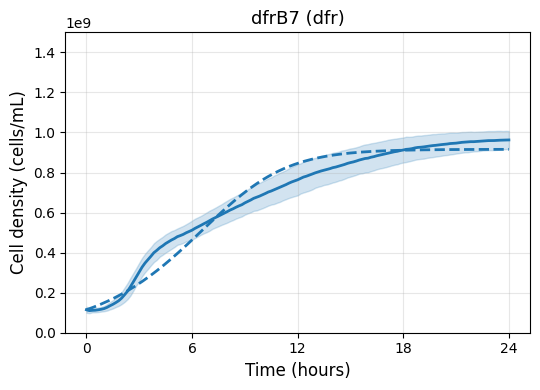

Saved fit for dfr/dfrB7 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB8 / dfr
Birth rate        : 0.7791
K                 : 1.9978
Consumption rate  : 1.4773e-09
SSE               : 1.421e+03
R²                : 0.9362


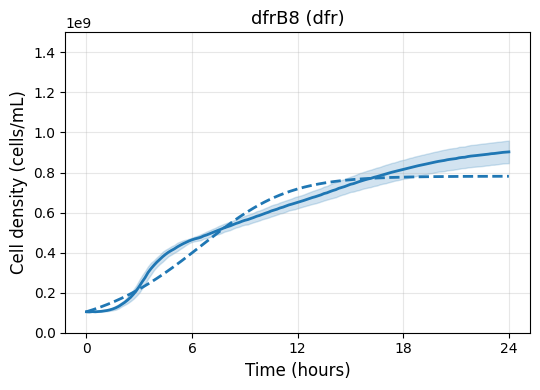

Saved fit for dfr/dfrB8 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : dfrB9 / dfr
Birth rate        : 0.7746
K                 : 1.9994
Consumption rate  : 1.3261e-09
SSE               : 2.817e+02
R²                : 0.9537


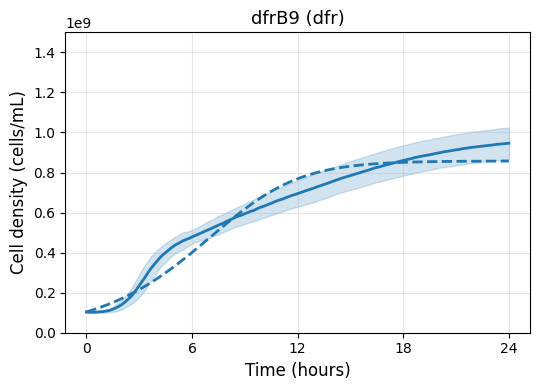

Saved fit for dfr/dfrB9 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : pMBA / dfr
Birth rate        : 0.9432
K                 : 1.9994
Consumption rate  : 1.0673e-09
SSE               : 4.432e+02
R²                : 0.9692


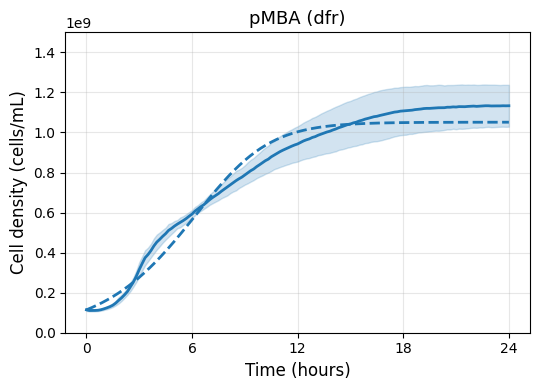

Saved fit for dfr/pMBA to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : arr2 / mix
Birth rate        : 0.1780
K                 : 0.0692
Consumption rate  : 1.2259e-09
SSE               : 1.983e+03
R²                : 0.9188


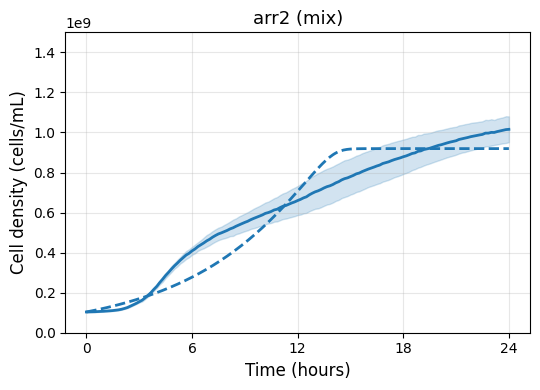

Saved fit for mix/arr2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : arr5 / mix
Birth rate        : 0.7897
K                 : 1.9919
Consumption rate  : 1.1929e-09
SSE               : 1.366e+03
R²                : 0.9805


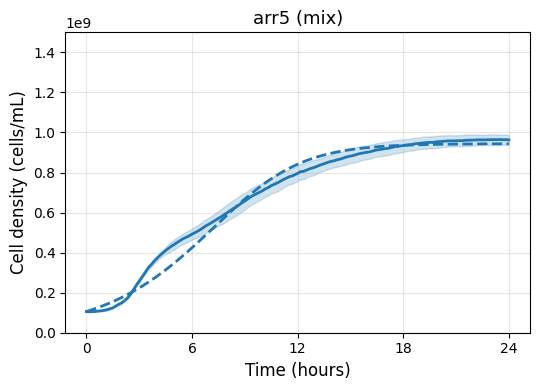

Saved fit for mix/arr5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : arr6 / mix
Birth rate        : 0.8944
K                 : 1.9997
Consumption rate  : 1.1913e-09
SSE               : 2.485e+03
R²                : 0.9727


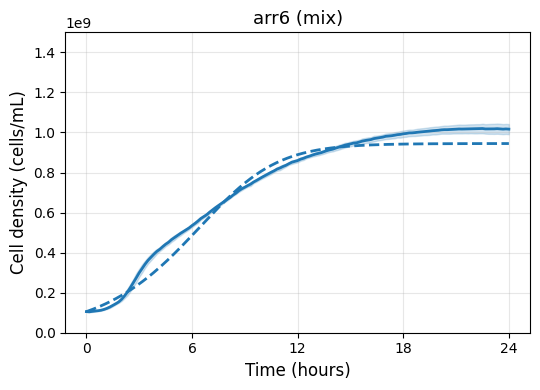

Saved fit for mix/arr6 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : arr7 / mix
Birth rate        : 1.0528
K                 : 1.9999
Consumption rate  : 1.2923e-09
SSE               : 9.551e+01
R²                : 0.9114


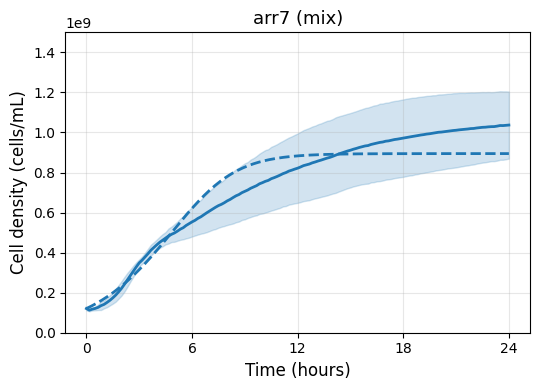

Saved fit for mix/arr7 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : arr8b / mix
Birth rate        : 0.3114
K                 : 0.1462
Consumption rate  : 1.1808e-09
SSE               : 1.740e+04
R²                : 0.9420


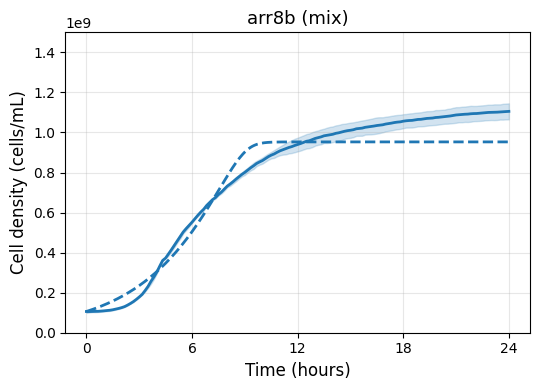

Saved fit for mix/arr8b to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : catB10 / mix
Birth rate        : 1.1016
K                 : 1.9986
Consumption rate  : 1.3886e-09
SSE               : 3.064e+03
R²                : 0.9079


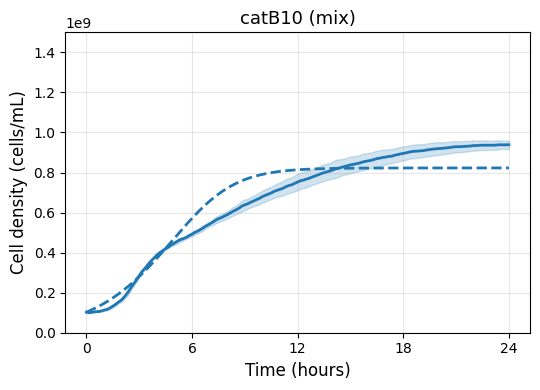

Saved fit for mix/catB10 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : catB2 / mix
Birth rate        : 0.1666
K                 : 0.0698
Consumption rate  : 1.5973e-09
SSE               : 9.073e+03
R²                : 0.9217


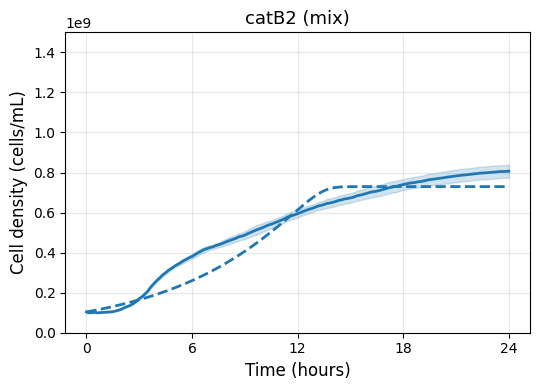

Saved fit for mix/catB2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : catB3 / mix
Birth rate        : 0.9880
K                 : 1.9989
Consumption rate  : 1.5756e-09
SSE               : 2.063e+03
R²                : 0.8962


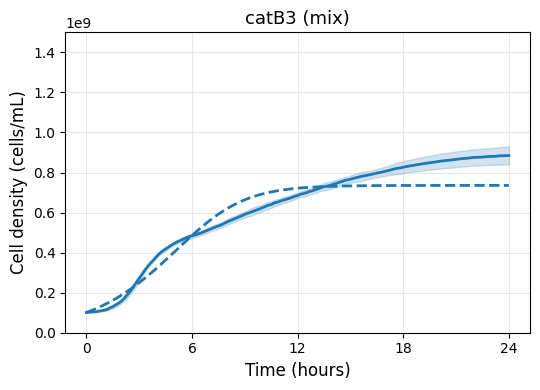

Saved fit for mix/catB3 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : catB5 / mix
Birth rate        : 0.8156
K                 : 1.9994
Consumption rate  : 1.3066e-09
SSE               : 1.917e+03
R²                : 0.9430


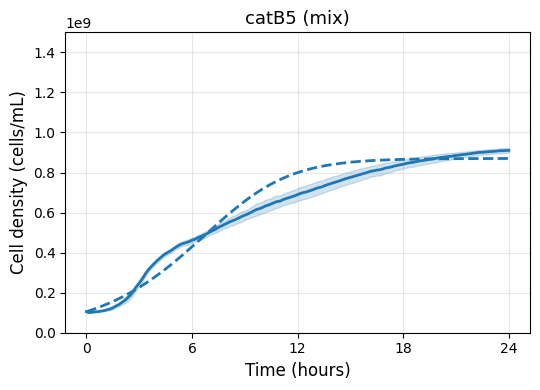

Saved fit for mix/catB5 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : catB6 / mix
Birth rate        : 1.0036
K                 : 1.9986
Consumption rate  : 1.4900e-09
SSE               : 4.406e+02
R²                : 0.8319


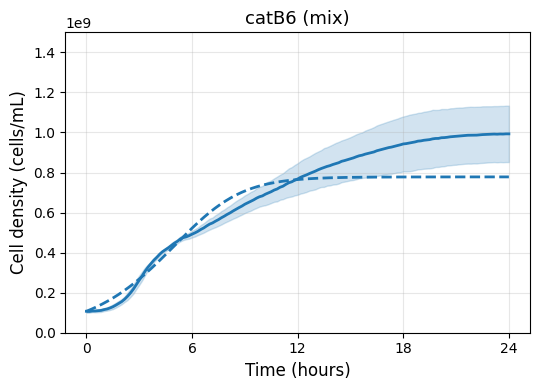

Saved fit for mix/catB6 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : ereA2 / mix
Birth rate        : 0.4836
K                 : 1.3741
Consumption rate  : 1.2926e-09
SSE               : 4.624e+02
R²                : 0.9708


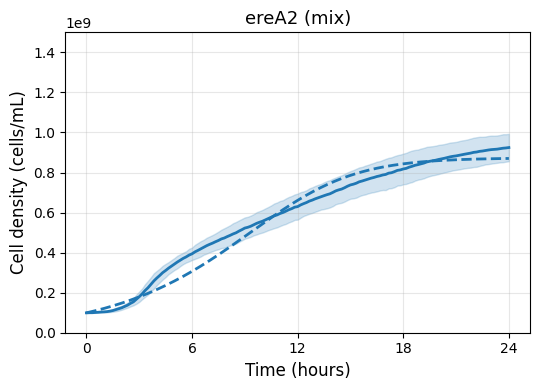

Saved fit for mix/ereA2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : ereA3 / mix
Birth rate        : 0.7725
K                 : 1.9985
Consumption rate  : 1.3080e-09
SSE               : 2.112e+02
R²                : 0.9566


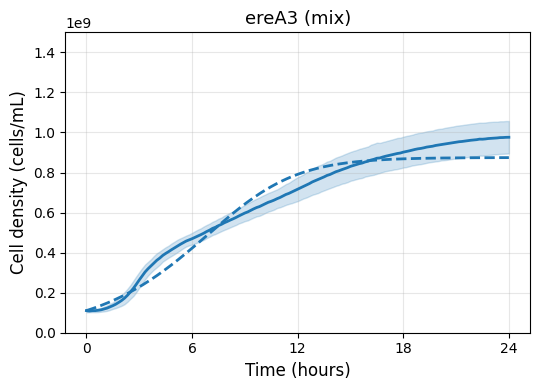

Saved fit for mix/ereA3 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosC2 / mix
Birth rate        : 0.8576
K                 : 1.9997
Consumption rate  : 1.0839e-09
SSE               : 5.624e+02
R²                : 0.9459


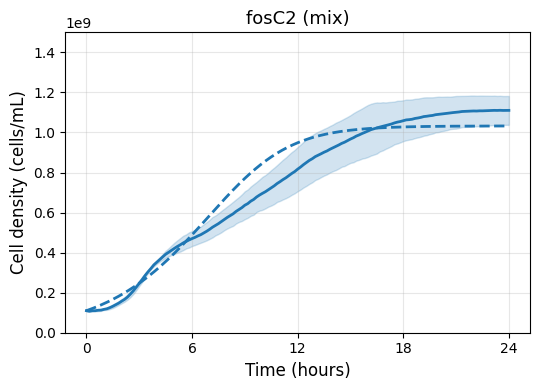

Saved fit for mix/fosC2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosE / mix
Birth rate        : 0.8978
K                 : 1.9997
Consumption rate  : 1.1487e-09
SSE               : 2.557e+02
R²                : 0.9697


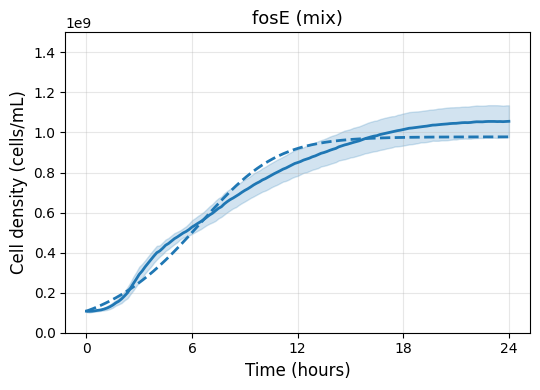

Saved fit for mix/fosE to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosF / mix
Birth rate        : 0.9169
K                 : 2.0000
Consumption rate  : 1.5739e-09
SSE               : 1.157e+03
R²                : 0.8228


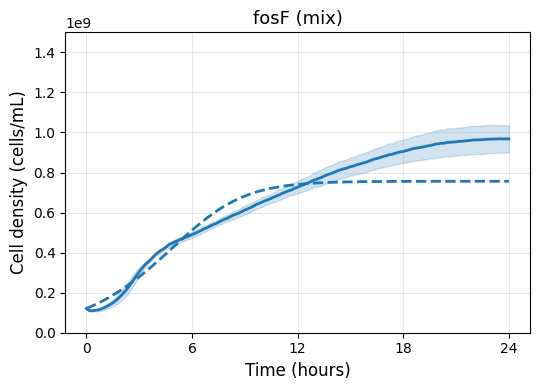

Saved fit for mix/fosF to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosG / mix
Birth rate        : 0.7303
K                 : 1.9997
Consumption rate  : 1.1575e-09
SSE               : 5.982e+02
R²                : 0.9231


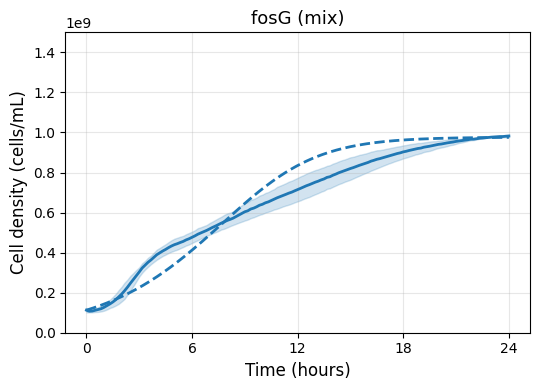

Saved fit for mix/fosG to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosH / mix
Birth rate        : 0.1500
K                 : 0.0508
Consumption rate  : 1.1625e-09
SSE               : 1.883e+04
R²                : 0.6429


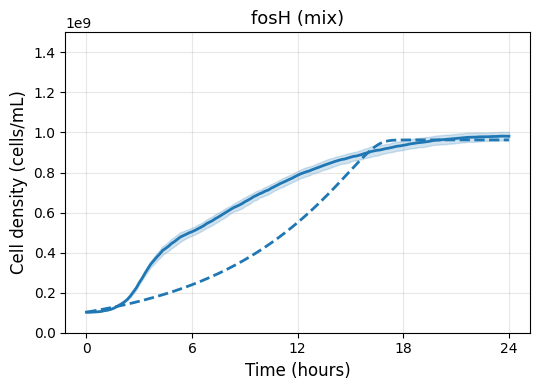

Saved fit for mix/fosH to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosI / mix
Birth rate        : 0.8523
K                 : 1.9994
Consumption rate  : 1.1159e-09
SSE               : 1.956e+02
R²                : 0.9741


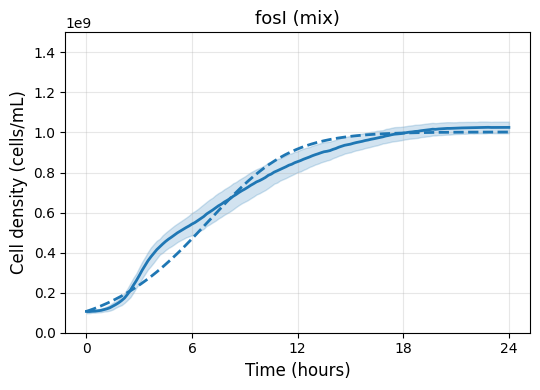

Saved fit for mix/fosI to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosK / mix
Birth rate        : 0.8822
K                 : 1.9998
Consumption rate  : 1.2541e-09
SSE               : 6.073e+02
R²                : 0.9437


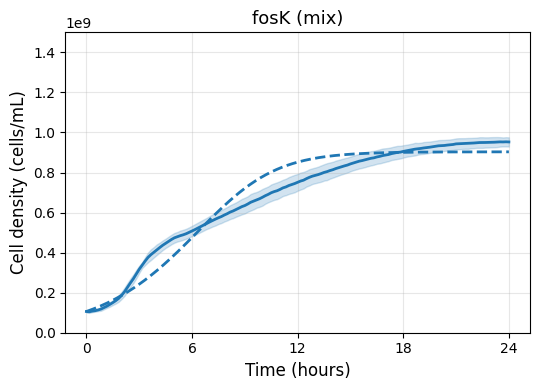

Saved fit for mix/fosK to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosL / mix
Birth rate        : 1.1323
K                 : 1.9996
Consumption rate  : 1.4182e-09
SSE               : 2.365e+02
R²                : 0.8731


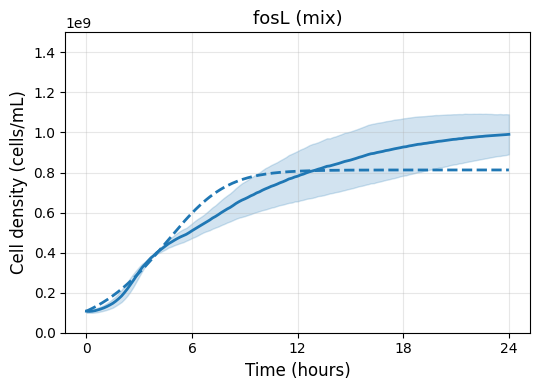

Saved fit for mix/fosL to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosM / mix
Birth rate        : 0.8951
K                 : 1.9991
Consumption rate  : 1.2531e-09
SSE               : 4.612e+02
R²                : 0.9325


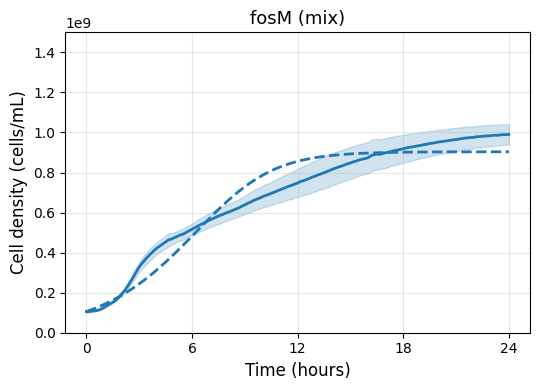

Saved fit for mix/fosM to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : fosN / mix
Birth rate        : 0.7319
K                 : 1.9996
Consumption rate  : 1.4089e-09
SSE               : 3.696e+03
R²                : 0.9384


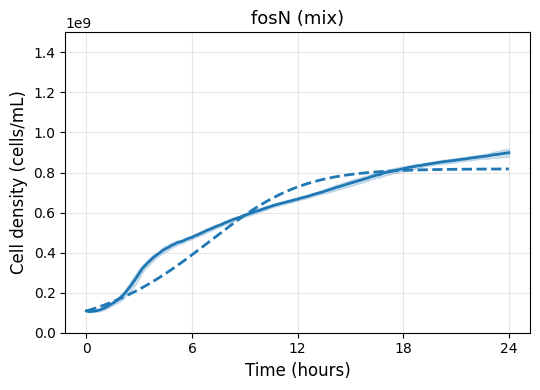

Saved fit for mix/fosN to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : pMBA / mix
Birth rate        : 0.9427
K                 : 1.9998
Consumption rate  : 1.0660e-09
SSE               : 4.432e+02
R²                : 0.9695


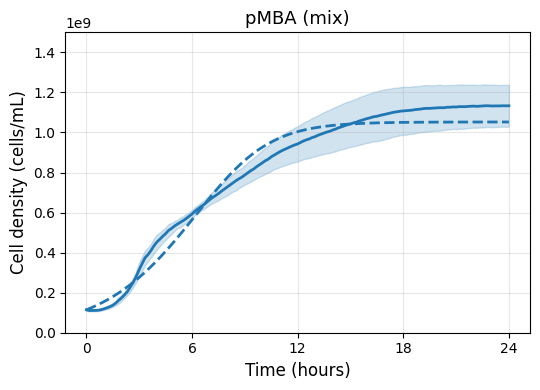

Saved fit for mix/pMBA to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacE / mix
Birth rate        : 0.3534
K                 : 0.4027
Consumption rate  : 1.4196e-09
SSE               : 8.599e+02
R²                : 0.9695


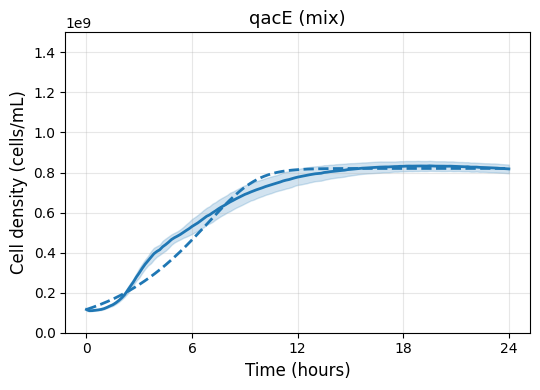

Saved fit for mix/qacE to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacEDsul1 / mix
Birth rate        : 0.4081
K                 : 0.4149
Consumption rate  : 1.7089e-09
SSE               : 2.074e+02
R²                : 0.9759


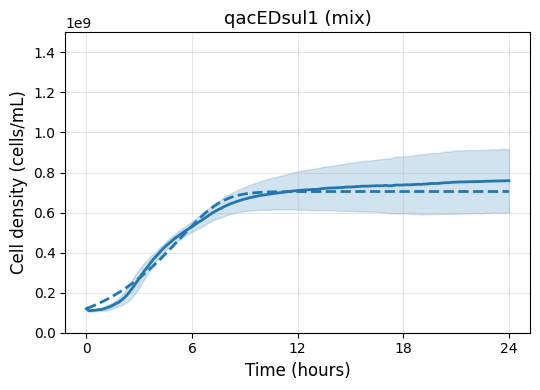

Saved fit for mix/qacEDsul1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacF / mix
Birth rate        : 0.8656
K                 : 2.0000
Consumption rate  : 1.0269e-09
SSE               : 1.819e+03
R²                : 0.9671


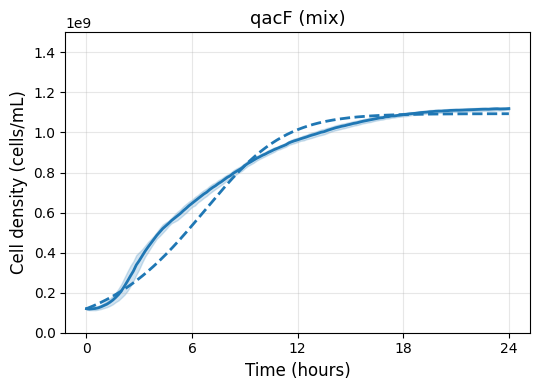

Saved fit for mix/qacF to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacG / mix
Birth rate        : 0.8808
K                 : 1.9990
Consumption rate  : 1.4584e-09
SSE               : 1.987e+02
R²                : 0.9682


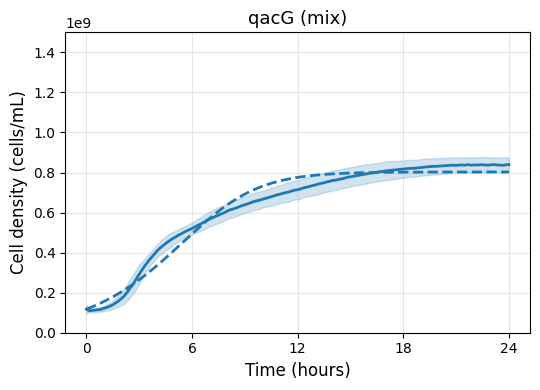

Saved fit for mix/qacG to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacH / mix
Birth rate        : 0.2846
K                 : 1.7951
Consumption rate  : 1.4234e-10
SSE               : 1.279e+03
R²                : 0.5279


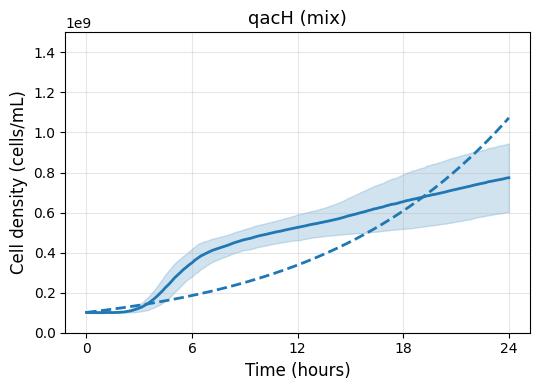

Saved fit for mix/qacH to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacK / mix
Birth rate        : 0.2365
K                 : 0.0500
Consumption rate  : 2.4516e-09
SSE               : 2.850e+02
R²                : 0.8731


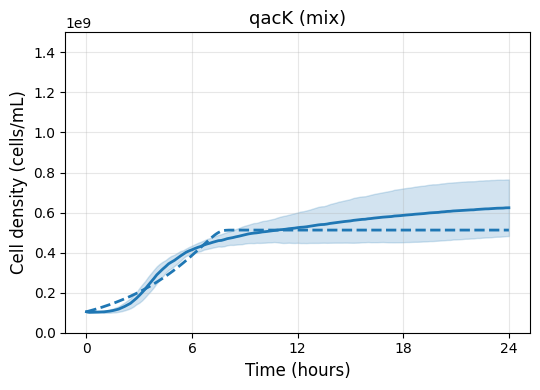

Saved fit for mix/qacK to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacL / mix
Birth rate        : 0.8726
K                 : 1.9997
Consumption rate  : 1.3000e-09
SSE               : 1.788e+03
R²                : 0.9260


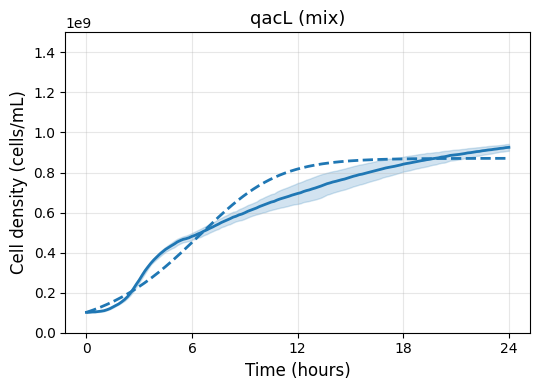

Saved fit for mix/qacL to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : qacM / mix
Birth rate        : 0.6624
K                 : 1.9997
Consumption rate  : 1.5224e-09
SSE               : 2.645e+02
R²                : 0.9721


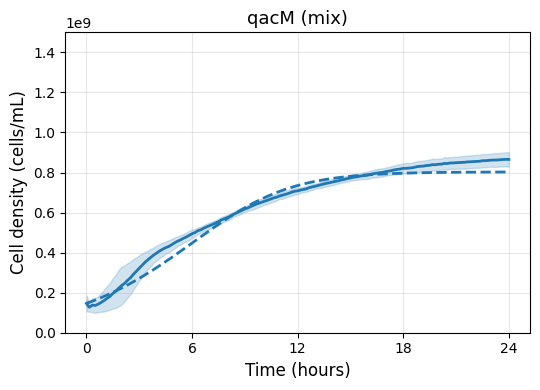

Saved fit for mix/qacM to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : sm3 / mix
Birth rate        : 0.9193
K                 : 1.9986
Consumption rate  : 9.7374e-10
SSE               : 4.004e+07
R²                : 0.9756


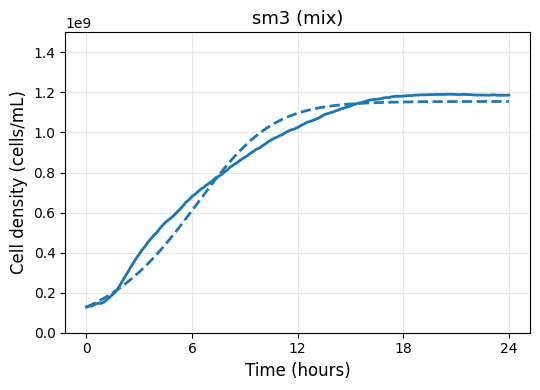

Saved fit for mix/sm3 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : smr1 / mix
Birth rate        : 0.9446
K                 : 1.9996
Consumption rate  : 1.3745e-09
SSE               : 3.842e+03
R²                : 0.8839


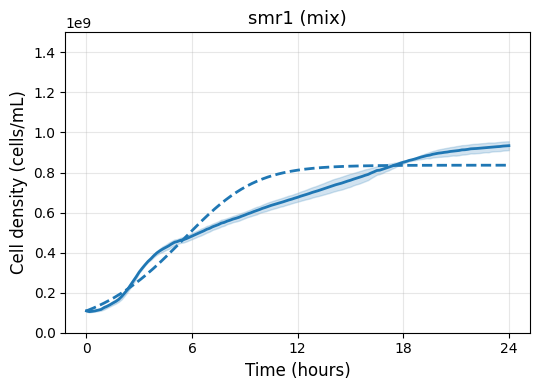

Saved fit for mix/smr1 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : smr2 / mix
Birth rate        : 0.9645
K                 : 1.9993
Consumption rate  : 1.4343e-09
SSE               : 9.617e+02
R²                : 0.9061


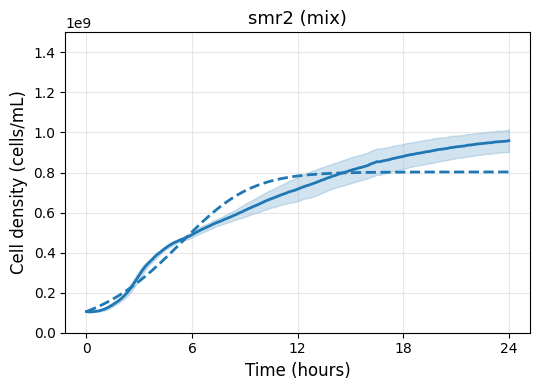

Saved fit for mix/smr2 to '/content/ARCfitness/data/params_fits.csv'.
=== Fit Summary ===
Strain/Family     : smr3 / mix
Birth rate        : 1.2048
K                 : 1.9973
Consumption rate  : 1.1560e-09
SSE               : 6.460e+02
R²                : 0.8874


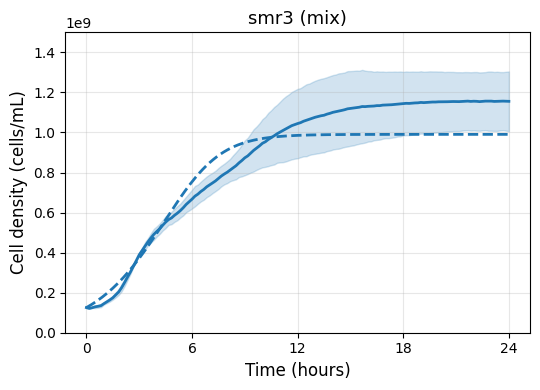

Saved fit for mix/smr3 to '/content/ARCfitness/data/params_fits.csv'.


In [ ]:
results_path = REPO_ROOT / "data" / "params_fits.csv"

for fam, strain in pairs_list:
    N0, fit, ax = fit_ODdata(
        OD_all, strain=strain, family=fam,
        sim_fn=gillespie_bacterial_growth_batch,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
    )

    plt.show()

    save_fit_to_csv(
        csv_path=results_path,
        fit=fit,
        strain=strain,
        family=fam,
        N0=N0,
        optimizer="de",
        od2cells=od2cells,
    )




---

